# VQA : Visual Question Answering

VQA is a task of free-form and open-ended Visual Question Answering (VQA). Given an image and a natural
language question about the image, the task is to provide an accurate natural language answer. Mirroring real-world scenarios, such
as helping the visually impaired, both the questions and answers are open-ended. Visual questions selectively target different areas
of an image, including background details and underlying context. As a result, a system that succeeds at VQA typically needs a
more detailed understanding of the image and complex reasoning than a system producing generic image captions. Moreover, VQA
is amenable to automatic evaluation, since many open-ended answers contain only a few words or a closed set of answers that can
be provided in a multiple-choice format. They have provided a dataset containing 0.25M images, 0.76M questions, and 10M answers
(www.visualqa.org).

### Paper references : arXiv:1505.00468 [cs.CL] , arXiv:1704.03162 [cs.CV], arXiv:1606.00061 [cs.CV]

#### Problem Statement:
Given the image and the question related to it, output the answer with decent accuracy. [Using top most 1000 answer labels and filtering the questions accordingly ]


#### Dataset: 

Dataset source : www.visualqa.org/download

2017 dataset:

Training annotations 2017 v2.0* : 4,437,570 answers
Validation annotations 2017 v2.0* : 2,143,540 answers

Training questions 2017 v2.0* : 443,757 questions
Validation questions 2017 v2.0* : 214,354 questions

Data format: Image folders containing .jpg images and json files consisting questions and answers.

#### Real world Objectives and constraints

1. Predict answers with decent accuracy.
2. Output should be given within few seconds.

### Deep Learning Problem:

#### Type of Problem:

It is a multi class classification problem using deep learning and computer vision techniques, which outputs only one label of class at end in form of answer in english.

#### Performance Metric:

##### Accuracy (Multi-Choice) :  Its the ratio of no. of correct answers predicted to no. of total predictions. Multi-Choice is, any value predicted should be in the multichoice answers for that question .

Accuracy = no. of correct predictions / no. of total predictions.
     

### Exploratory Data Analysis:
#### Loading Data:

In [0]:
# importing required libraries
import os
import json
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision import models 
from tqdm import tqdm
from PIL import Image
import re
import pickle
import h5py
from matplotlib.pyplot import imshow


plt.ion()

from torch import nn
import torch.nn.functional  as F

SEED = 1234
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.benchmark=True

In [0]:
# loading data paths to variables
annotations_train_json = 'v2_Annotations_Train_mscoco/v2_mscoco_train2014_annotations.json'
annotations_val_json = 'v2_Annotations_Val_mscoco/v2_mscoco_val2014_annotations.json'
questions_train_json = 'v2_Questions_Train_mscoco/v2_OpenEnded_mscoco_train2014_questions.json'
questions_val_json = 'v2_Questions_Val_mscoco/v2_OpenEnded_mscoco_val2014_questions.json'
images_train_folder = 'train2014/'
images_val_folder = 'val2014/'

In [0]:
# loading json files as json lists
train_questions_list = json.load(open(questions_train_json))
val_questions_list = json.load(open(questions_val_json))
train_annotations_list = json.load(open(annotations_train_json))
val_annotations_list = json.load(open(annotations_val_json))

In [0]:
# extracting questions, answers, multiple_choice_answer and answer type
train_list = train_questions_list['questions']
val_list = val_questions_list['questions']
for i in range(len(train_list)):
    train_list[i]['multiple_choice_answer'] = train_annotations_list['annotations'][i]['multiple_choice_answer']
    train_list[i]['answers'] = train_annotations_list['annotations'][i]['answers']
    train_list[i]['answer_type'] = train_annotations_list['annotations'][i]['answer_type']
for i in range(len(val_list)):
    val_list[i]['multiple_choice_answer'] = val_annotations_list['annotations'][i]['multiple_choice_answer']
    val_list[i]['answers'] = val_annotations_list['annotations'][i]['answers']
    val_list[i]['answer_type'] = val_annotations_list['annotations'][i]['answer_type']

In [0]:
with open('train_val_lists.pkl', 'wb') as f:
    pickle.dump([train_list, val_list], f)

{'image_id': 393221,
 'question': 'Is the sky blue?',
 'question_id': 393221000,
 'multiple_choice_answer': 'yes',
 'answers': [{'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 1},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 2},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 3},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 4},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 5},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 6},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 7},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 8},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 9},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 10}],
 'answer_type': 'yes/no'}

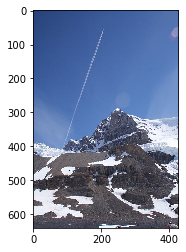

In [0]:
imshow(Image.open('train2014/COCO_train2014_'+str(train_list[10]['image_id']).rjust(12, '0')+'.jpg'))
train_list[10]

#### Every train sample and val sample has : 
- image_id says about the file name where image is located,
- question,
- answe_type like yes/no, number and other,
- one open end answer,
- upto 10 multi choice answers.


In [0]:
def make_df(json_list):
    answer_type = []
    multiple_choice_answer = []
    image_id = []
    question = []
    for i in range(len(json_list)):
        answer_type.append(json_list[i]['answer_type'])
        multiple_choice_answer.append(json_list[i]['multiple_choice_answer'])
        image_id.append(json_list[i]['answer_type'])
        question.append(json_list[i]['multiple_choice_answer'])
    return pd.DataFrame(zip(answer_type, multiple_choice_answer, image_id, question), columns = ['answer_type', 'multiple_choice_answer', 'image_id', 'question'])

train_df = make_df(train_list)
val_df = make_df(val_list)

### Distribution of train samples:

No of train samples :  443757


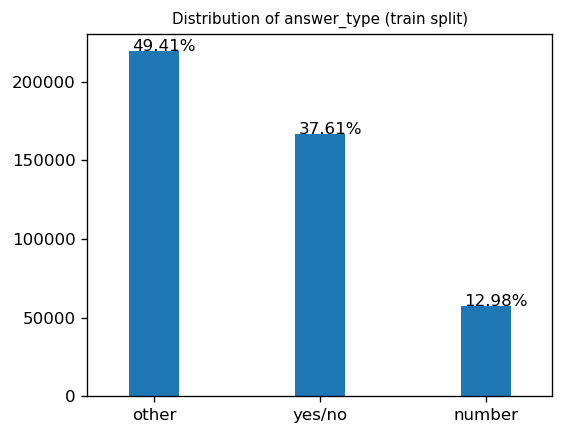

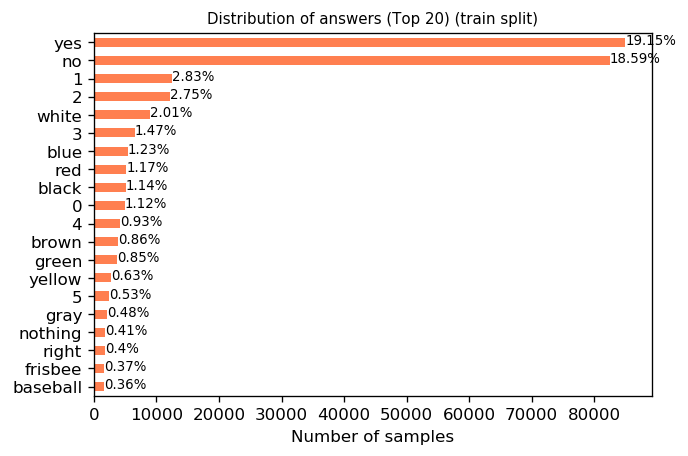

In [0]:
print('No of train samples : ' , len(train_list))

ax = train_df['answer_type'].value_counts().plot(kind='bar', figsize=(5,4), rot = 0, width = 0.3)
percentages = (train_df['answer_type'].value_counts()/ len(train_df) *100)[:10]
ax.set_title("Distribution of answer_type (train split)", size = 9)

for i in range(len(percentages)):
    ax.text(ax.patches[i].get_x()+0.02, ax.patches[i].get_height(), str( round(percentages[i], 2))+'%')
    
plt.rcParams["figure.dpi"] = 120
plt.show()


ax = train_df['multiple_choice_answer'].value_counts()[:20].plot(kind='barh', color = 'coral', figsize=(6,4))
percentages = (train_df['multiple_choice_answer'].value_counts()/ len(train_df) *100)[:20]
ax.set_title("Distribution of answers (Top 20) (train split)", size = 9)
ax.set_xlabel("Number of samples")

for i in range(len(percentages)):
    ax.text(ax.patches[i].get_width()+0.35, ax.patches[i].get_y()+0.35, str( round(percentages[i], 2))+'%', size = 8)

ax.invert_yaxis()
plt.rcParams["figure.dpi"] = 120
plt.show()

### Distribution of val samples:

No of val samples :  214354


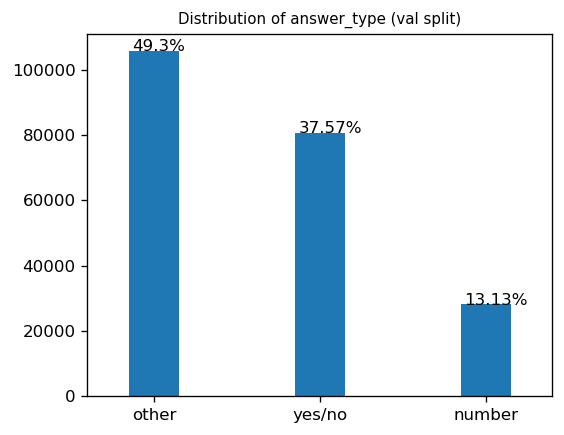

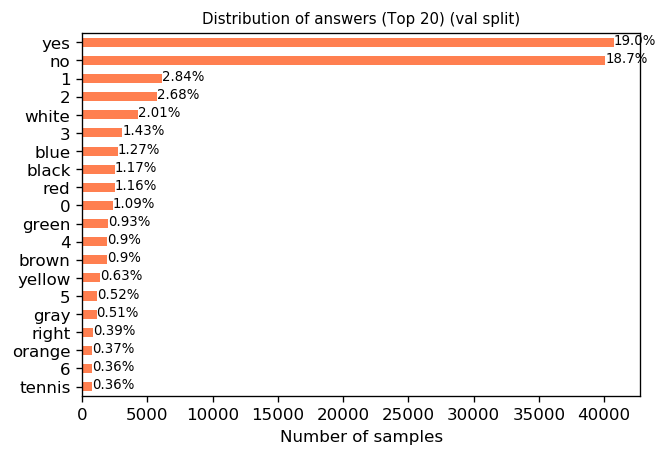

In [0]:
print('No of val samples : ' , len(val_list))

ax = val_df['answer_type'].value_counts().plot(kind='bar', figsize=(5,4), rot = 0, width = 0.3)
percentages = (val_df['answer_type'].value_counts()/ len(val_df) *100)[:10]
ax.set_title("Distribution of answer_type (val split)", size = 9)

for i in range(len(percentages)):
    ax.text(ax.patches[i].get_x()+0.02, ax.patches[i].get_height(), str( round(percentages[i], 2))+'%')
    
plt.rcParams["figure.dpi"] = 120
plt.show()


ax = val_df['multiple_choice_answer'].value_counts()[:20].plot(kind='barh', color = 'coral', figsize=(6,4))
percentages = (val_df['multiple_choice_answer'].value_counts()/ len(val_df) *100)[:20]
ax.set_title("Distribution of answers (Top 20) (val split)", size = 9)
ax.set_xlabel("Number of samples")

for i in range(len(percentages)):
    ax.text(ax.patches[i].get_width()+0.35, ax.patches[i].get_y()+0.35, str( round(percentages[i], 2))+'%', size = 8)

ax.invert_yaxis()#### Both train and validation splits have same distribution.
plt.rcParams["figure.dpi"] = 120
plt.show()

#### Both train and validation splits have same distribution.

As paper suggests, we are using only top 1000 answer labels.

In [0]:
MAX_LENGTH_QUESTION = 0
LONG_Q = ''
for i in train_list:
    length = len(i['question'].split())
    if(length > MAX_LENGTH_QUESTION):
        MAX_LENGTH_QUESTION = length
        LONG_Q = i['question']
        LONG_QA = i['answers'][0]['answer']
        
print('Maximum words in question: ', MAX_LENGTH_QUESTION)
print('QUESTION : ', LONG_Q)
print('ANSWER : ', LONG_QA)

Maximum words in question:  22
QUESTION :  Does the couch on the left of  the frame appear to be larger than the one on the right of the frame?
ANSWER :  yes


#### Since the maximum words in question are 22, we will take max length of 25 words for every question.

### Extracting Image features from vgg19bn pretrained pytorch model:

 Here we extract and store the features to use them repeatedly in analysing models which helps in faster processing. 

To use num_workers>0 feature in pytorch dataloader, we need to wrap code in seperate .py file under main wrapper.

In [0]:
# %load extract_vgg_features.py
import pickle
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision import models
from PIL import Image
import pickle
import jpeg4py as jpeg
import imghdr
import h5py
from tqdm import tqdm

from torch import nn
import torch.nn.functional  as F
from utils import *

transform = transforms.Compose([
transforms.Resize((224,224)),
transforms.ToTensor(),
transforms.Normalize(
mean=[0.485, 0.456, 0.406],
std=[0.229, 0.224, 0.225]
)])

class ImageDataset(Dataset):
    def __init__(self, json_list, split):
        self.imgids = list(set([i['image_id'] for i in json_list]))
        self.split = split

    def __len__(self):
        return len(self.imgids)

    def __getitem__(self, index):
        '''
        returns 2 tensors: image features tensor, imgid tensor.
        '''
        file = self.split+'2014/COCO_'+self.split+'2014_'+str(self.imgids[index]).rjust(12, '0')+'.jpg'
        if(imghdr.what(file) == 'jpeg'):
            item = {'image': transform(Image.fromarray(jpeg.JPEG(file).decode()))}
        else:
            item = {'image': transform(Image.open(file).convert('RGB'))}

        item['id'] = self.imgids[index]
        return item

if __name__ == '__main__':

    num_workers = int(sys.argv[1])
    batch_size = int(sys.argv[2])
    split = sys.argv[3]

    # loading the pytorch pretrained vgg 19 batchnormalized model
    w_vgg19 =  models.vgg19_bn(pretrained = True)

    # This keeps only first layer in classifier class in the model 
    w_vgg19.classifier = nn.Sequential(*list(w_vgg19.classifier.children()))[:-3]

    # setting vgg19 to evaluation mode and transfer to GPU.
    model = w_vgg19.eval().to('cuda')


    with open('train_val_lists.pkl', 'rb') as f:
        train_list, val_list = pickle.load(f)

    if(split == 'train'):
        list_json = train_list

    if(split == 'val'):
        list_json = val_list


    img_loader = DataLoader(
        ImageDataset(list_json, split),
        batch_size= batch_size,
        num_workers=num_workers,
        shuffle=False,
        pin_memory=True,
        )

    del train_list
    del val_list
    del list_json

    model.to('cuda')
    model.eval()
    
    with h5py.File(img_loader.dataset.split+'_imgs_vgg.h5', libver='latest', mode = 'w') as f:
        img_features = f.create_dataset('img_features', shape=(len(img_loader.dataset), 4096), dtype='float16')
        img_ids = f.create_dataset('img_ids', shape=(len(img_loader.dataset),), dtype='int32')

        i = j = 0
        for data in tqdm(img_loader):
            imgs = data['image'].to('cuda')

            with torch.no_grad():
                out = model(imgs)

            j = i + imgs.size(0)
            img_features[i:j, :] = out.cpu().numpy().astype('float16')
            img_ids[i:j] = data['id'].numpy().astype('int32')
            i = j


In [0]:
# num_workers = 4, batch_size = 64, split = 'train'
%run extract_vgg_features.py 4 64 train

100%|██████████████████████████████████████████████████████████████████████████████| 1294/1294 [41:22<00:00,  1.92s/it]


In [0]:
# num_workers = 4, batch_size = 64, split = 'val'
%run extract_vgg_features.py 4 64 val

100%|████████████████████████████████████████████████████████████████████████████████| 633/633 [19:21<00:00,  1.84s/it]


In [0]:
img_feat_dict_train = {}
img_feat_dict_val = {}

img_h5 = h5py.File('train_imgs_vgg.h5', libver='latest', mode = 'r')
img_features = img_h5['img_features']
img_ids_list = list(img_h5['img_ids'])
for i in range(len(img_ids_list)):
    img_feat_dict_train[img_ids_list[i]] = img_features[i]

img_h5 = h5py.File('val_imgs_vgg.h5', libver='latest', mode = 'r')
img_features = img_h5['img_features']
img_ids_list = list(img_h5['img_ids'])
for i in range(len(img_ids_list)):
    img_feat_dict_val[img_ids_list[i]] = img_features[i]

with open('img_feats_dicts_vgg19.pickle', 'wb') as f:
    pickle.dump(img_feat_dict_train, f)
    pickle.dump(img_feat_dict_val, f)

#### Utility Functions for Text Processing:

In [0]:
def tokenize(sentence):
    '''
    splits the sentence at whitespaces, any special characters like , ? / etc
    and outputs a list of tokens
    '''
    sentence = sentence.lower()
    return [i for i in re.split(r"([-!\$#.\"',:? @~();\[\]/\\\+<>\n*&\^%=])", sentence) if
            i != '' and i != ' ' and i != '\n']

def create_question_vocab(qa_list):
    '''
    Creates vocabulary for given json formatted dataset
    '''
    # appending pad and unknown characters to vocab 
    vocab = ['<PAD>', '<UNK>']  
    
    # obtaining unique words from the data 
    vocab += sorted(list(set([w for q in qa_list for w in tokenize(q['question'])])))
    
    # making a dict to get its index quickly
    vocab_dict = {}
    for i in range(len(vocab)):
        vocab_dict[vocab[i]] = i 
        
    return vocab_dict
            
def encode_questions(qa_list, question_vocab, max_length = 25):
    '''
    Given data json and vocab. This function encodes each question into 25 length list
    
    '''
    encoded_questions = []
    
    #converting each token in question to id using vocab dict
    questions_to_ids = [[question_vocab.get(i, question_vocab['<UNK>']) for i in tokenize(q['question'])] for q in qa_list]
    
    #padding 0s if length is <25 and truncating if it exceeds 25.
    for q in questions_to_ids:
        length = len(q)
        if(length < max_length):
            q += [question_vocab['<PAD>'] for i in range(max_length - length)]
        else:
            q = q[:max_length]
            
        encoded_questions.append(q)
    return encoded_questions

def create_answer_vocab(qalist, top = 1000):
    '''
    return the top numbered answers from given dataset json list
    '''
    counts = {}
    # counting the occurence of each answers
    for annotation in qalist:
        for answer in annotation['answers']:
            a = answer['answer'].lower()
            counts[a] = counts.get(a, 0) + 1
        a = annotation['multiple_choice_answer'].lower()
        counts[a] = counts.get(a, 0) + 1

    # sorting the answers based on the count in descending order.
    sorted_ans = sorted([(count, ans) for ans, count in counts.items()], reverse = True)
    answers = [sorted_ans[i][1] for i in range(top)][:-1] + ['<UNK>']
    
    answer_vocab = {}
    for i in range(len(answers)):
        answer_vocab[answers[i]] = i 
        
    return answer_vocab

def encode_answers(qa_list, answer_vocab):
    '''
    returns list of indexes corresponding to top_answers 
    '''
    encoded_answers = []
    encoded_multi_answers = []
    for annotation in qa_list:
        # unique multi answers
        all_answers = list(set([answer["answer"] for answer in annotation['answers']]))
        
        #storing answers which are in answer vocab
        valid_answers = [a for a in all_answers if a in answer_vocab]
        if(len(valid_answers) == 0):
            valid_answers = ['<UNK>']
        
        answers = [answer_vocab[answer] for answer in valid_answers]
        multi_answers = [-11]*10 #for dataloader, all dimensions must be same.
        multi_answers[:len(valid_answers)] = answers
        encoded_multi_answers.append(multi_answers)
        
        # encode multiple_choice_answer if its in vocab else picks random answer from multi_answers.
        encoded_answers.append(answer_vocab.get(annotation['multiple_choice_answer'], np.random.choice(answers)))
        
    return encoded_answers, np.array(encoded_multi_answers)

def filter_dataset(qa_list, answer_type):
    '''
    filters the dataset based on the given answer type
    '''
    return [x for x in qa_list if(x['answer_type'] == answer_type) ]

In [0]:
# for plotting 
def draw_plots(n_batches_train, n_batches_val, train_losses, train_accs, val_losses, val_accs, per_step_cummulative = False):
    epochs = int(len(train_losses)/n_batches_train)
    if(per_step_cummulative):
        train_space = np.arange(0, epochs, 1/n_batches_train)
        val_space = np.arange(0, epochs, 1/n_batches_val)
    else:
        train_space, val_space = np.arange(1, epochs+1), np.arange(1, epochs+1)
        train_losses = [train_losses[idx] for idx in range(0, len(train_losses), n_batches_train)]
        train_accs = [train_accs[idx] for idx in range(0, len(train_accs), n_batches_train)]
        val_losses = [val_losses[idx] for idx in range(0, len(val_losses), n_batches_val)]
        val_accs = [val_accs[idx] for idx in range(0, len(val_accs), n_batches_val)]

    fig, axs = plt.subplots(1,2 ,figsize = (10,4), dpi = 200)
    if(per_step_cummulative):
        fig.suptitle('Loss and Accuracy Plots (cummulative steps per epoch)')
    else:
        fig.suptitle('Loss and Accuracy Plots')
    fig.subplots_adjust(hspace= 0.4)

    axs[0].set_title('Loss Plot')
    axs[0].plot(train_space, train_losses)
    axs[0].plot(val_space, val_losses)
    axs[0].set_xticks(range(0, epochs+1, 5))
    axs[0].legend(['train_loss', 'val_loss'])
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')

    axs[1].set_title('Accuracy Plot')
    axs[1].plot(train_space, train_accs)
    axs[1].plot(val_space, val_accs)
    axs[1].set_xticks(range(0, epochs+1, 5))
    axs[1].legend(['train_acc', 'val_acc'])
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    
    plt.show()

### Data Preparation: 

In [0]:
with open('train_val_lists.pkl', 'rb') as f:
    train_list, val_list = pickle.load(f)

In [0]:
# creating vocabulary for questions and answers
answer_vocab = create_answer_vocab(train_list)
question_vocab = create_question_vocab(train_list)

In [0]:
with open('vocab.pkl', 'wb') as f:
    pickle.dump([question_vocab, answer_vocab], f)

In [0]:
class VQADataset(Dataset):
    def __init__(self, json_list, question_vocab, answer_vocab, split, train_img_feats = None, val_img_feats = None, answer_type = None):
        self.text_data = json_list
        # based on split type, image features are initialized in the class.
        if(split == 'train'):
            self.img_feats = train_img_feats
        elif(split == 'val'):
            self.img_feats = val_img_feats
            if (answer_type != None):
                self.text_data = filter_dataset(json_list, answer_type)            
            
        self.questions_encoded = encode_questions(self.text_data, question_vocab)
        self.answers_encoded, self.multi_answers = encode_answers(self.text_data, answer_vocab)
        
    def __len__(self):
        return len(self.text_data)

    def __getitem__(self, index):
        '''
        returns 3 tensors: image features tensor, encoded question tensor, encoded answer tensor.
        '''
        item = {'image': torch.tensor(self.img_feats[self.text_data[index]['image_id']].astype('float32')).view(-1)}
        item['question'] = torch.tensor(self.questions_encoded[index])
        item['answer'] = torch.tensor(self.answers_encoded[index], dtype = torch.long)
        item['multi_answer'] = torch.tensor(self.multi_answers[index], dtype = torch.long)
        return item

In [0]:
# loading vgg pretrained features from previously saved dictionaries.
with open('img_feats_dicts_vgg19.pickle', 'rb') as f:
    img_feat_dict_train = pickle.load(f)
    img_feat_dict_val = pickle.load(f)

In [0]:
batch_size = 256
train_dataloader = DataLoader(VQADataset(train_list, 
                                         question_vocab,
                                         answer_vocab,
                                         split = 'train',
                                         train_img_feats = img_feat_dict_train),
                            batch_size=batch_size, shuffle = True)
# Testing dataloader
next(iter(train_dataloader))

{'image': tensor([[-0.1350,  0.5322, -1.0303,  ...,  0.5405, -1.9297, -1.2197],
         [-1.0391, -2.1465,  1.7461,  ..., -1.6641, -1.6875, -2.1348],
         [ 0.7500, -1.7090, -0.1089,  ..., -1.2930,  0.6680,  1.4170],
         ...,
         [ 0.0754, -1.8721,  0.2029,  ..., -0.0079, -0.1080,  0.0256],
         [ 0.5537,  0.3877, -1.3223,  ..., -0.4058,  0.2798, -0.7017],
         [ 1.4043, -1.1621, -0.0807,  ..., -0.6675,  0.2600, -1.0195]]),
 'question': tensor([[12832,  6123,  5907,  ...,     0,     0,     0],
         [ 3547, 11736,  6951,  ...,     0,     0,     0],
         [ 3547, 11736, 11909,  ...,     0,     0,     0],
         ...,
         [ 5751,  6992,  6949,  ...,     0,     0,     0],
         [ 6123, 11736,   884,  ...,     0,     0,     0],
         [ 3547,  6133,  6799,  ...,     0,     0,     0]]),
 'answer': tensor([100,   0,   0, 248,   4, 580,   0,   0, 661,   0, 202, 172,   1,   1,
           9, 681, 999,   0, 444, 999,   1, 151, 407,  74,   0, 157,   4,   0,

### Deep Learning Model: (Deeper LSTM-Q +norm I)

 Now we are going to implement the same model in the paper in pytorch framework.

![](readme_imgs/img.jpg)


![](readme_imgs/img1.jpg)
![](readme_imgs/img2.jpg)

In [0]:
batch_size = 256

train_dataloader = DataLoader(VQADataset(train_list, 
                                         question_vocab,
                                         answer_vocab,
                                         split = 'train',
                                         train_img_feats = img_feat_dict_train 
                                    ),
                                   batch_size=batch_size, shuffle = True)
val_dataloader = DataLoader(VQADataset(val_list, 
                                        question_vocab,
                                        answer_vocab,
                                        split = 'val',
                                        val_img_feats = img_feat_dict_val 
                                    ),
                                   batch_size=batch_size, shuffle = False)

#### Here, replaced all activations with gelu as its known for better performance with NLP models.

In [0]:
class DeeperLSTM_QI(nn.Module):
    def __init__(self, vocab_size, img_dim, dropout_p = 0.5):
        
        super(DeeperLSTM_QI, self).__init__()
        
        # initializing the layers 
        self.embedding = nn.Embedding(vocab_size, 300, padding_idx = question_vocab['<PAD>'])
        self.fc_embed = nn.Linear(300, 300)
        self.lstm = nn.LSTM(300, 512, num_layers =2, batch_first = True)
        self.fc_lstm = nn.Linear(4*512, 1024)
        self.fc_i = nn.Linear(img_dim, 1024)
        self.fc1 = nn.Linear(1024, 1000)
        self.fc2 = nn.Linear(1000, 1000)
        self.dropout = nn.Dropout(dropout_p)
        
        # initializing weights
        self.init_weights()
 

    def forward(self, img_feat_input, text_input):

        # embedding layer: [batch_size, 25] to [batch_size, 25, 300]
        # with gelu non-linearity
        text_embedded = F.gelu(self.fc_embed(self.embedding(text_input)))
        
        # lstm layer (hidden, cell): [batch_size, 25, 300] to [2, batch_size, 512]
        _, (lstm_hidden, lstm_cell)  = self.lstm(text_embedded)

        # 4 *[batch_size, 512] to [batch_size, 2048]
        lstm_concat = torch.cat([lstm_hidden[0], lstm_hidden[1], lstm_cell[0], lstm_cell[1]], 1)
        
        # [batch_size, 2048] to [batch_size, 1024] fully connected with gelu non-linearity
        fc_lstm = self.dropout(F.gelu(self.fc_lstm(lstm_concat)))
        
        # Fully connected layer which embeds image into L2-normalized 1024d vector
        # [batch_size, 4096] -> [batch_size, 1024]
        fc_i = F.gelu(self.fc_i(F.normalize(img_feat_input, dim = 1, p=2)))
        
        # point-wise multiplication of 2 [batch_size, 1024] matrices.
        pw_mul = fc_i * fc_lstm
        
        # [batch_size, 1024] to [batch_size, 1024]
        fc_1 = self.dropout(F.gelu(self.fc1(self.dropout(pw_mul))))

        # output: [batch_size, 1000]
        output = F.softmax(self.fc2(fc_1), dim=1)
        
        return output
    
    def init_weights(self):
        
        # kaiming_uniform is same as he_uniform initialization
        init = torch.nn.init.kaiming_uniform_
        for layer in self.lstm.all_weights:
            for hidden in layer[:2]:
                init(hidden)
                
        init(self.fc_embed.weight)
        init(self.fc_lstm.weight)
        init(self.fc_i.weight)
        init(self.fc1.weight)
        init(self.fc2.weight)

In [0]:
from torch.optim import lr_scheduler

# Initializing the model with train vocab, img_dim, dropout = 0.5
model = DeeperLSTM_QI(len(question_vocab),4096, dropout_p = 0.5)

device = torch.device('cuda:0')

# NLLLoss as loss function because we have already used softmax in last layer of model.
unk_answer_idx = answer_vocab['<UNK>'] # to ignore unknown answer index
criterion = torch.nn.NLLLoss(ignore_index = unk_answer_idx).to(device)

# Using Adamax optimizer
optimizer = torch.optim.Adamax(model.parameters(), lr =0.001)

epochs = 20

onecycle_scheduler = lr_scheduler.OneCycleLR(optimizer, steps_per_epoch = train_dataloader.__len__(), max_lr = 0.005, epochs = epochs)

# feeding model into GPU
model.to(device)

# setting model state to train
model.train()

DeeperLSTM_QI(
  (embedding): Embedding(13156, 300, padding_idx=0)
  (fc_embed): Linear(in_features=300, out_features=300, bias=True)
  (lstm): LSTM(300, 512, num_layers=2, batch_first=True)
  (fc_lstm): Linear(in_features=2048, out_features=1024, bias=True)
  (fc_i): Linear(in_features=4096, out_features=1024, bias=True)
  (fc1): Linear(in_features=1024, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [0]:
from datetime import datetime as dt
import warnings
warnings.filterwarnings("ignore")

cell_start = dt.now()

unk_answer_idx = answer_vocab['<UNK>']

n_batches_train = train_dataloader.__len__()
n_batches_val = val_dataloader.__len__()
train_len = train_dataloader.dataset.__len__()
val_len = val_dataloader.dataset.__len__()
train_losses = []
val_losses = []
train_accs = []
val_accs = []

min_loss = 99

for epoch in range(epochs):
    
    start = dt.now()
    train_loss = 0
    train_correct = 0
    model = model.train()

    for batch, data in enumerate(train_dataloader):
        
        # unzipping data and loading it to GPU
        data['image'], data['question'] = data['image'].to(device), data['question'].to(device)
        multi_ans = data['multi_answer']
        answers = data['answer']
        
        # zeroing the previous optimizer calculations
        optimizer.zero_grad()
        
        output = model(data['image'], data['question'])
        
        # modifying answers tensor by replacing wrong output answers with possible multi answers.(using CPU)
        predictions = torch.argmax(output.cpu(), 1)
        indices = torch.where(~(answers == predictions))[0]
        for idx in indices:
            if predictions[idx] in multi_ans[idx]:
                answers[idx] = multi_ans[idx][torch.where(multi_ans[idx] == predictions[idx])[0].item()]

        loss = criterion(torch.log(output+0.000001),  answers.cuda())
        
        # backpropagating loss
        loss.backward()   
            
        optimizer.step()
        onecycle_scheduler.step()
        
        predictions[predictions == unk_answer_idx] = -1   # ignoring unknown answer
        train_correct += (predictions == answers).sum().item()
        train_loss += loss.item()
        
        train_accs.append(train_correct/(min((batch+1)*batch_size, train_len)))
        train_losses.append(train_loss/(batch+1)) 
        print('\r Epoch: {}  Batches: {}/{} loss: {:.5f} acc: {:.4f}'.format(epoch+1, batch+1, n_batches_train, train_losses[-1], train_accs[-1], train_len), end= '')
    
    val_correct = 0
    val_loss = 0
    with torch.no_grad():
        model = model.eval()
        for batch, data in enumerate(val_dataloader):
            
            data['image'], data['question'] = data['image'].to(device), data['question'].to(device)
            multi_ans = data['multi_answer']
            answers = data['answer']

            output = model(data['image'], data['question'])

            # modifying answers tensor by replacing wrong output answers with possible multi answers.
            predictions = torch.argmax(output.cpu(), 1)
            indices = torch.where(~(answers == predictions))[0]
            for idx in indices:
                if predictions[idx] in multi_ans[idx]:
                    answers[idx] = multi_ans[idx][torch.where(multi_ans[idx] == predictions[idx])[0].item()]

            vloss = criterion(torch.log(output+0.000001),  answers.cuda())
            
            predictions[predictions == unk_answer_idx] = -1 #to ignore unknown answer
            val_correct += (predictions == answers).sum().item()
            val_loss += vloss.item()
            
            val_accs.append(val_correct/(min((batch+1)*batch_size, val_len)))
            val_losses.append(val_loss/(batch+1))   
        print(' val_loss: {:.5f} val_acc: {:.4f} [{}]'.format(val_losses[-1], val_accs[-1], dt.now()-start ))
    
    torch.save(model.state_dict(),'saved/model_11_state_dict')
    
    # Earlystopping with patience 5.
    if(val_losses[-1] < min_loss):
        # saving best model to disk
        torch.save(model.state_dict(), 'saved/model_11_es_state_dict')
        min_loss = val_losses[-1]
        patience = 0
    else:
        patience += 1
        
    if(patience == 3):
        print('\n EarlyStopped. ')
        break

# saving accuracies and losses for plotting later.
with open('saved/plot_data_11.pkl','wb') as f:
    pickle.dump([n_batches_train, n_batches_val, train_losses, train_accs, val_losses, val_accs], f) 
    
print('\n Total time taken to run this cell: ', dt.now() - cell_start)

 Epoch: 1  Batches: 1734/1734 loss: 3.49873 acc: 0.3480 val_loss: 2.87382 val_acc: 0.3973 [0:03:49.923180]
 Epoch: 2  Batches: 1734/1734 loss: 2.76506 acc: 0.4142 val_loss: 2.36750 val_acc: 0.4554 [0:03:52.171849]
 Epoch: 3  Batches: 1734/1734 loss: 2.33371 acc: 0.4558 val_loss: 2.02567 val_acc: 0.4974 [0:03:56.469167]
 Epoch: 4  Batches: 1734/1734 loss: 2.06982 acc: 0.4853 val_loss: 1.83295 val_acc: 0.5265 [0:03:49.290598]
 Epoch: 5  Batches: 1734/1734 loss: 1.91660 acc: 0.5079 val_loss: 1.76753 val_acc: 0.5337 [0:03:46.170905]
 Epoch: 6  Batches: 1734/1734 loss: 1.81914 acc: 0.5228 val_loss: 1.69143 val_acc: 0.5484 [0:03:42.544605]
 Epoch: 7  Batches: 1734/1734 loss: 1.74219 acc: 0.5369 val_loss: 1.65022 val_acc: 0.5564 [0:03:43.618731]
 Epoch: 8  Batches: 1734/1734 loss: 1.67765 acc: 0.5478 val_loss: 1.62392 val_acc: 0.5615 [0:03:48.614415]
 Epoch: 9  Batches: 1734/1734 loss: 1.62069 acc: 0.5588 val_loss: 1.59855 val_acc: 0.5665 [0:03:47.593099]
 Epoch: 10  Batches: 1734/1734 loss: 

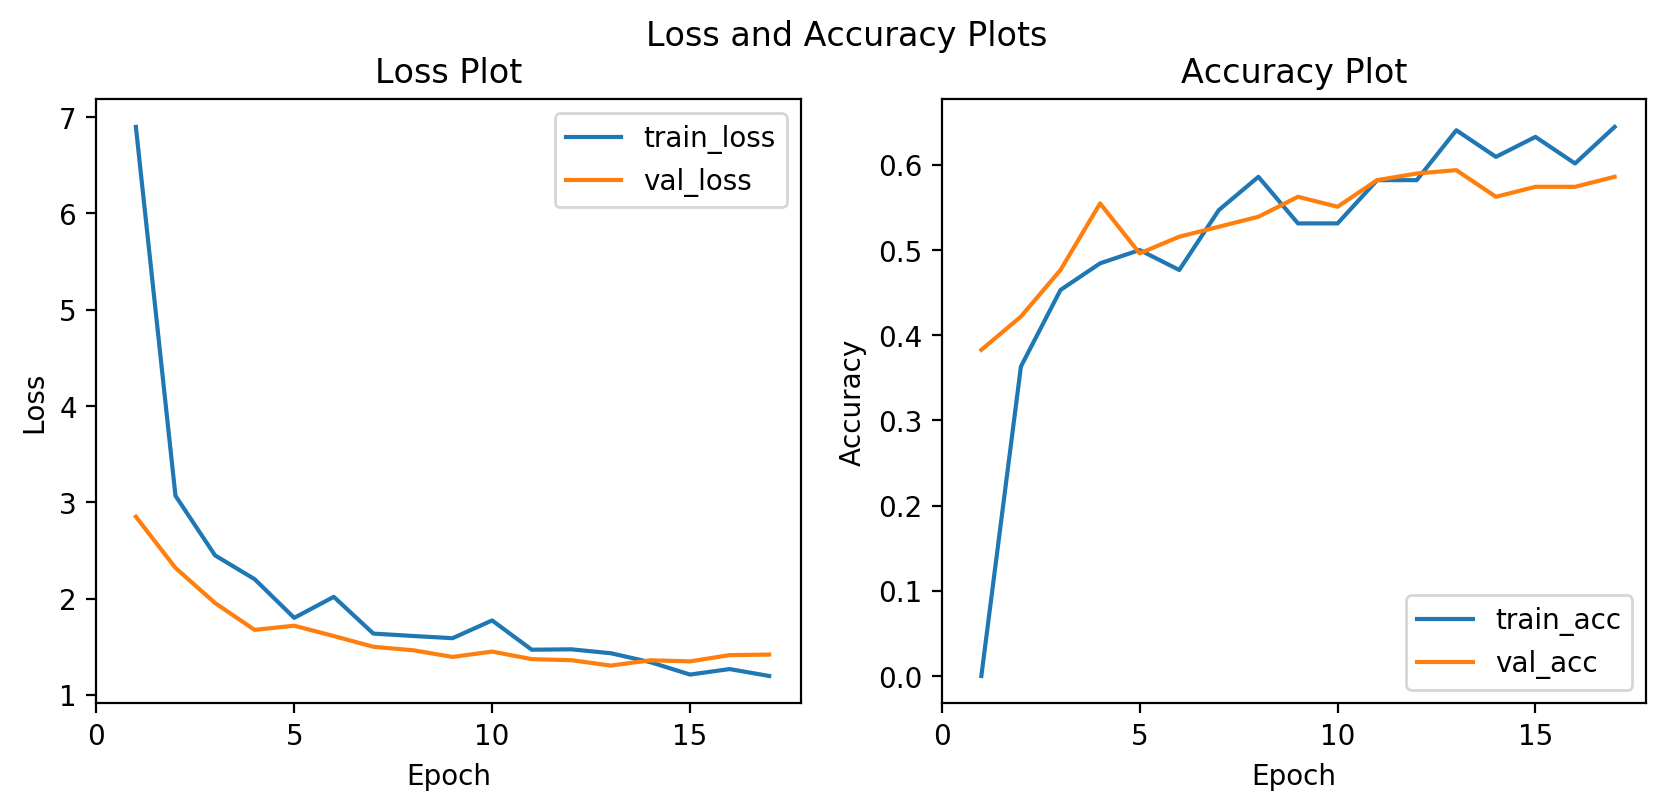

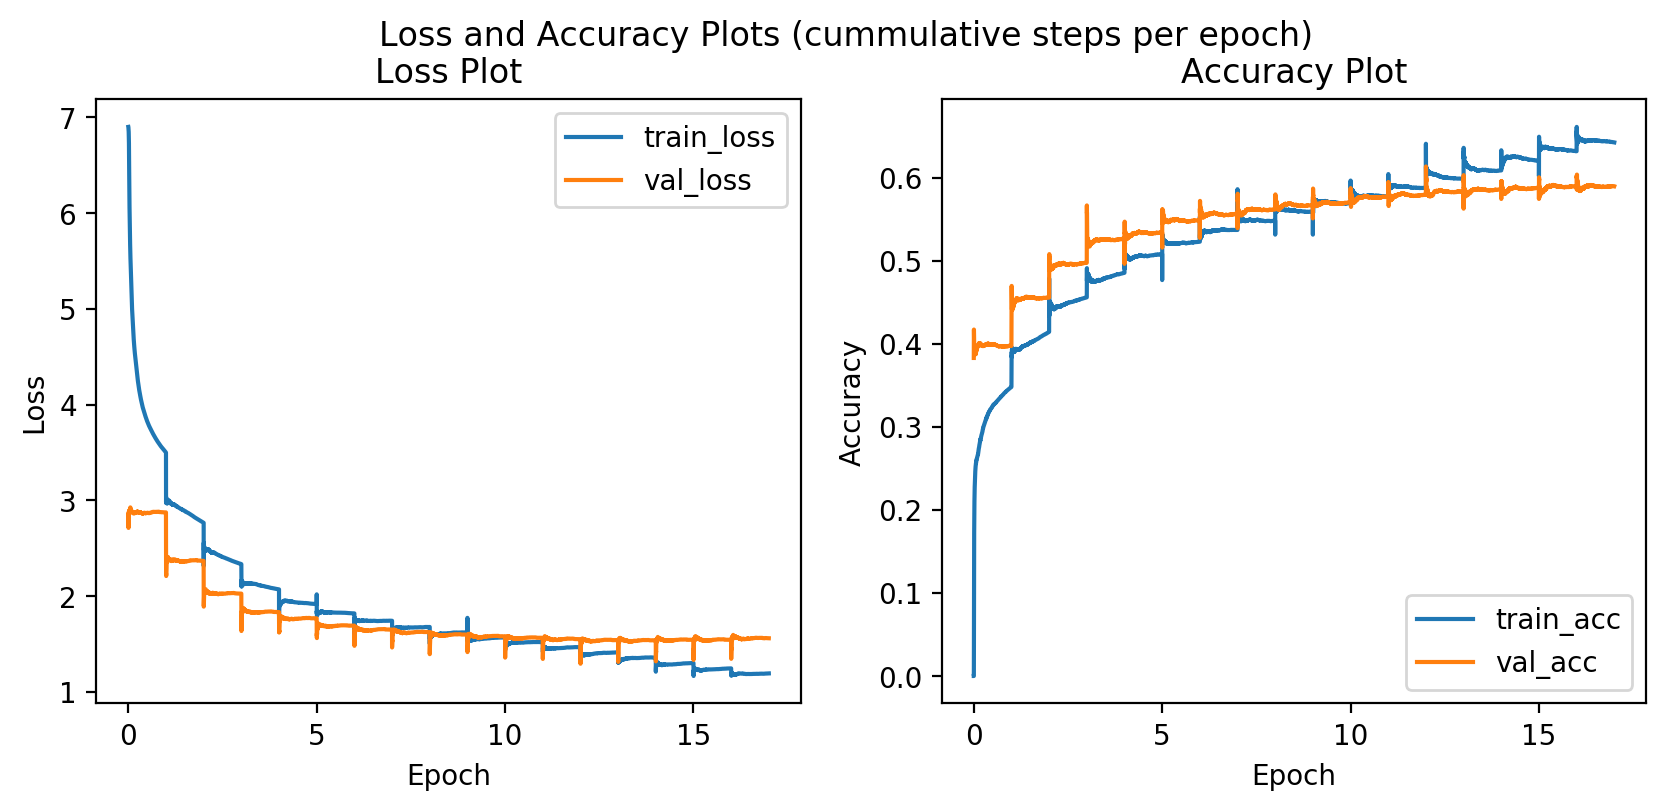

In [0]:
with open('saved/plot_data_11.pkl','rb') as f:
    n_batches_train, n_batches_val, train_losses, train_accs, val_losses, val_accs = pickle.load(f) 

draw_plots( n_batches_train, n_batches_val, train_losses, train_accs, val_losses, val_accs,
           per_step_cummulative = False)

draw_plots( n_batches_train, n_batches_val, train_losses, train_accs, val_losses, val_accs,
           per_step_cummulative = True)

## Deep Learning Model 2: (Deeper LSTM_Q + norm_I with Attention)

We are going to use the Attention mechanism similar to model in the paper <b>arXiv:1704.03162</b>

![](readme_imgs/img4.jpg)

> - Here we used <b>wide_resnet101</b> <i>1024x14x14</i> img features instead of <i>2048x14x14</i> from <b>resnet152</b> in paper.<br>
> - gelu activations.<br>
> - 1000 output labels.
> - and some changes.

### Extracting 1024x14x14 features for each image from wide_resnet101_2 model and saving to disk.

To use num_workers>0 feature in pytorch dataloader, we need to wrap code in seperate .py file under main wrapper.

In [0]:
# %load extract_resnet_features.py
import pickle
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision import models
from PIL import Image
import pickle
import jpeg4py as jpeg
import imghdr
import h5py
from tqdm import tqdm

from torch import nn
import torch.nn.functional  as F
from utils import *

transform = transforms.Compose([
transforms.Resize((224,224)),
transforms.ToTensor(),
transforms.Normalize(
mean=[0.485, 0.456, 0.406],
std=[0.229, 0.224, 0.225]
)])

class ImageDataset(Dataset):
    def __init__(self, json_list, split):
        self.imgids = list(set([i['image_id'] for i in json_list]))
        self.split = split


    def __len__(self):
        return len(self.imgids)

    def __getitem__(self, index):
        '''
        returns 2 tensors: image features tensor, imgid tensor.
        '''
        file = 'C:/'+self.split+'2014/COCO_'+self.split+'2014_'+str(self.imgids[index]).rjust(12, '0')+'.jpg'
        if(imghdr.what(file) == 'jpeg'):
            item = {'image': transform(Image.fromarray(jpeg.JPEG(file).decode()))}
        else:
            item = {'image': transform(Image.open(file).convert('RGB'))}

        item['id'] = self.imgids[index]
        return item

if __name__ == '__main__':

    num_workers = int(sys.argv[1])
    batch_size = int(sys.argv[2])
    split = sys.argv[3]

    w_resnet =  models.wide_resnet101_2(pretrained = True)

    # removing last layer4 sequential, last avgpool and linear layers to get 1024*14*14 features
    w_resnet = nn.Sequential(*list(w_resnet.children())[:-3])

    # storing modified resnet in resenet_mod
    resnet_mod = nn.Sequential(*list(w_resnet.children()))


    with open('train_val_lists.pkl', 'rb') as f:
        train_list, val_list = pickle.load(f)

    if(split == 'train'):
        list_json = train_list

    if(split == 'val'):
        list_json = val_list


    img_loader = DataLoader(
        ImageDataset(list_json, split),
        batch_size= batch_size,
        num_workers=num_workers,
        shuffle=False,
        pin_memory=True,
        )

    del train_list
    del val_list
    del list_json

    resnet_mod.to('cuda')
    resnet_mod.eval()
    
    with h5py.File(img_loader.dataset.split+'_imgs_resnet.h5', libver='latest', mode = 'w') as f:
        img_features = f.create_dataset('img_features', shape=(len(img_loader.dataset), 1024, 14, 14), dtype='float16')
        img_ids = f.create_dataset('img_ids', shape=(len(img_loader.dataset),), dtype='int32')

        i = j = 0
        for data in tqdm(img_loader):
            imgs = data['image'].to('cuda')

            with torch.no_grad():
                out = resnet_mod(imgs)

            j = i + imgs.size(0)
            img_features[i:j, :, :] = out.cpu().numpy().astype('float16')
            img_ids[i:j] = data['id'].numpy().astype('int32')
            i = j


In [0]:
# num_workers = 3, batch_size = 64, split = 'train'
%run extract_resnet_features.py 3 64 train

100%|██████████████████████████████████████████████████████████████████████████████| 1294/1294 [31:01<00:00,  1.44s/it]


In [0]:
# num_workers = 3, batch_size = 128, split = 'val'
%run extract_resnet_features.py 3 128 val

100%|████████████████████████████████████████████████████████████████████████████████| 317/317 [12:28<00:00,  2.36s/it]


### Defining the model:

#### Here, replaced all activations with gelu as its known for better performance with NLP models.

In [0]:
class DeeperLSTM_QI_Att(nn.Module):
    def __init__(self, vocab_size, img_dim, dropout_p = 0.5):

        super(DeeperLSTM_QI_Att, self).__init__()

        # defining the layers
        self.embedding = nn.Embedding(vocab_size, 512, padding_idx = 0)
        self.fc_embed = nn.Linear(512, 512)
        self.lstm = nn.LSTM(512, 1024, num_layers =2, bidirectional = True, batch_first = True)
        self.fc_cell = nn.Linear(1024, 1024)

        self.attention = Attention(img_dim)
        self.fc1 = nn.Linear(2048+1024, 1024)
        self.fc2 = nn.Linear(1024, 1000)
        self.dropout = nn.Dropout(dropout_p)
        # initializing weights
        self.init_weights()


    def forward(self, img_input, text_input):

        # embedding layer: [batch_size, 25] to [batch_size, 25, 512]
        # with gelu non-linearity
        text_embedded = F.gelu(self.fc_embed(self.embedding(text_input)))

        # lstm layer (hidden, cell): [batch_size, 25, 512] to [2, batch_size, 1024]
        _, (_, lstm_cell)  = self.lstm(text_embedded)

        # lstm_cell[-1] gets cell state of 2nd layer
        # [batch_size, 1024] to [batch_size, 1024]
        question_feats = self.dropout(F.gelu(self.fc_cell(lstm_cell[-1])))

        # L2-normalized img feats
        img_feats = F.normalize(img_input, dim = 1, p=2)

        weighted_img_attention = self.attention(img_feats, question_feats)

        # [batch_size, 2048+1024]
        combined = torch.cat([weighted_img_attention, question_feats], dim = 1)

        # [batch_size, 2048] to [batch_size, 1024]
        fc_1 = self.dropout(F.gelu(self.fc1(combined)))

        # output: [batch_size, 1000]
        output = F.softmax(self.fc2(fc_1), dim=1)

        return output

    def init_weights(self):

        # kaiming_uniform is same as he_uniform initialization
        init = torch.nn.init.kaiming_uniform_
        for layer in self.lstm.all_weights:
            for hidden in layer[:2]:
                init(hidden)

        init(self.fc_embed.weight)
        init(self.attention.img_conv.weight)
        init(self.attention.glimpse_conv.weight)
        init(self.fc_cell.weight)
        init(self.fc1.weight)
        init(self.fc2.weight)

class Attention(nn.Module):
    def __init__(self, img_dim = 2048, glimpses = 2):
        super(Attention, self).__init__()

        self.glimpses  = glimpses
        self.img_conv = nn.Conv2d(img_dim, 1024, 1)
        self.glimpse_conv = nn.Conv2d(1024, glimpses, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, i_feats, q_feats):

        # [batch_size, 1024, 14, 14] to [batch_size, 1024, 14, 14] since 1x1 filters.
        i = F.gelu(self.img_conv(i_feats))
        
        # Repeating q_feats in all spatial positions of i conv features
        # [batch_size, 1024] to [batch_size, 1024, 14, 14]
        q = q_feats.view(q_feats.size()[0], q_feats.size()[1], 1, 1).expand_as(i)
        
        # adding both i and q features
        combined = F.gelu(i + q)
        
        # getting attention features by passing combined into 2 glimpse conv2d
        # [batch_size, 1024, 14, 14] to [batch_size, 2, 14, 14]
        glimpse_conv = self.dropout(F.gelu(self.glimpse_conv(combined)))
        
        # [batch_size, 2, 14, 14] to [batch_size, 2, 14*14]
        glimpse_conv = glimpse_conv.view(i_feats.size()[0], self.glimpses, -1)
        
        # softmax across 2 (14*14) features
        # [batch_size, 2, 14*14] to [batch_size, 2, 1, 14*14]
        attention = F.softmax(glimpse_conv, dim=-1).unsqueeze(2)

        # [batch_size, 1024, 14, 14] to [batch_size, 1, 1024, 14*14] : unsqueeze 2nd dim and flatten 3rd dim
        i_feats = i_feats.view(i_feats.size()[0], 1, i_feats.size()[1], -1)
        
        # [batch_size, 1, 1024, 14*14] i.e., multiplying 1024 (14*14) i_feats with 14*14 attention for 2 glimpses.
        weighted = attention * i_feats

        # [batch_size, 2, 1024, 14*14] to [batch_size, 2048]
        weighted_mean = weighted.sum(dim=-1).view(i_feats.size()[0], -1)

        return weighted_mean


### Training the model:

All required functions are stored in utils.py

To use num_workers>0 feature in pytorch dataloader, we need to wrap code in seperate .py file under main wrapper.

In [0]:
# %load att_model_training.py
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision import models
import re
import pickle
from torch.optim import lr_scheduler
import h5py


from torch import nn
import torch.nn.functional  as F
from utils import *


SEED = 1234
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.benchmark=True

class VQADataset_I(Dataset):
    def __init__(self, json_list, question_vocab, answer_vocab, split = None):
        self.text_data = json_list
        self.split = split

        self.questions_encoded = encode_questions(self.text_data, question_vocab)
        self.answers_encoded, self.multi_answers = encode_answers(self.text_data, answer_vocab)

    def __len__(self):
        return len(self.text_data)

    def __getitem__(self, index):

        # h5 objects cant be pickled when declared in __init__
        if not hasattr(self, 'img_h5'):
            self.img_h5 = h5py.File(self.split+'_imgs_resnet.h5', libver='latest', mode = 'r')
            self.img_features = self.img_h5['img_features']
            img_ids_list = list(self.img_h5['img_ids'])
            self.img_ids = {}
            for i in range(len(img_ids_list)):
                self.img_ids[img_ids_list[i]] = i

        '''
        returns 4 tensors: image tensor, encoded question tensor, encoded answer tensor, multi answer tensor.
        '''
        item = {}
        item['image'] = torch.tensor(self.img_features[self.img_ids[self.text_data[index]['image_id']]], dtype = torch.float32)
        item['question'] = torch.tensor(self.questions_encoded[index])
        item['answer'] = torch.tensor(self.answers_encoded[index], dtype = torch.long)
        item['multi_answer'] = torch.tensor(self.multi_answers[index], dtype = torch.long)
        return item


if __name__ == '__main__':

    num_workers = int(sys.argv[1])
    batch_size = int(sys.argv[2])

    with open('vocab.pkl', 'rb') as f:
        question_vocab, answer_vocab = pickle.load(f)

    with open('train_val_lists.pkl', 'rb') as f:
        train_list, val_list = pickle.load(f)

    train_dataset = VQADataset_I(train_list,
                                 question_vocab,
                                 answer_vocab,
                                split = 'train')
    val_dataset = VQADataset_I(val_list,
                                question_vocab,
                                answer_vocab,
                                split = 'val')

    del train_list
    del val_list

    train_dataloader = DataLoader(train_dataset,
                                batch_size=batch_size, shuffle = True, num_workers = num_workers, pin_memory = True)

    val_dataloader = DataLoader(val_dataset,
                                batch_size=batch_size, shuffle = False, num_workers = num_workers, pin_memory = True)



    device = torch.device('cuda:0')
    epochs = 20

    model = DeeperLSTM_QI_Att(len(question_vocab),1024, dropout_p = 0.5)
    optimizer = torch.optim.Adamax(model.parameters(), lr =0.001)

    onecycle_scheduler = lr_scheduler.OneCycleLR(optimizer, steps_per_epoch = train_dataloader.__len__(), max_lr = 0.005, epochs = epochs)
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    unk_answer_idx = answer_vocab['<UNK>'] # to ignore unknown answer index
    criterion = torch.nn.NLLLoss(ignore_index = unk_answer_idx).to(device)

    model.to(device)

    n_batches_train = train_dataloader.__len__()
    n_batches_val = val_dataloader.__len__()
    train_len = train_dataloader.dataset.__len__()
    val_len = val_dataloader.dataset.__len__()

    min_loss = 99

    for epoch in range(epochs):

        start = dt.now()
        train_loss = 0
        train_correct = 0
        model = model.train()

        for batch, data in enumerate(train_dataloader):

            # unzipping data and loading it to GPU
            data['image'], data['question'] = data['image'].to(device), data['question'].to(device)
            multi_ans = data['multi_answer']
            answers = data['answer']

            # zeroing the previous optimizer calculations
            optimizer.zero_grad()

            output = model(data['image'], data['question'])

            # modifying answers tensor by replacing wrong output answers with possible multi answers.
            predictions = torch.argmax(output.cpu(), 1)
            indices = torch.where(~(answers == predictions))[0]
            for idx in indices:
                if predictions[idx] in multi_ans[idx]:
                    answers[idx] = multi_ans[idx][torch.where(multi_ans[idx] == predictions[idx])[0].item()]

            loss = criterion(torch.log(output+0.000001),  answers.cuda())

            # backpropagating loss
            loss.backward()

            optimizer.step()
            onecycle_scheduler.step()

            predictions[predictions == unk_answer_idx] = -1 #to ignore unknown answer
            train_correct += (predictions == answers).sum().item()
            train_loss += loss.item()

            train_accs.append(train_correct/(min((batch+1)*batch_size, train_len)))
            train_losses.append(train_loss/(batch+1))
            printout = '\r Epoch: {}  Batches: {}/{} loss: {:.5f} acc: {:.4f}'.format(epoch+1, batch+1, n_batches_train, train_losses[-1], train_accs[-1], train_len)
            print(printout, end = '')
            
        val_correct = 0
        val_loss = 0
        with torch.no_grad():
            model = model.eval()
            for batch, data in enumerate(val_dataloader):

                data['image'], data['question'] = data['image'].to(device), data['question'].to(device)
                multi_ans = data['multi_answer']
                answers = data['answer']

                output = model(data['image'], data['question'])

                # modifying answers tensor by replacing wrong output answers with possible multi answers.
                predictions = torch.argmax(output.cpu(), 1)
                indices = torch.where(~(answers == predictions))[0]
                for idx in indices:
                    if predictions[idx] in multi_ans[idx]:
                        answers[idx] = multi_ans[idx][torch.where(multi_ans[idx] == predictions[idx])[0].item()]

                vloss = criterion(torch.log(output+0.000001),  answers.cuda())

                predictions[predictions == unk_answer_idx] = -1 #to ignore unknown answer
                val_correct += (predictions == answers).sum().item()
                val_loss += vloss.item()

                val_accs.append(val_correct/(min((batch+1)*batch_size, val_len)))
                val_losses.append(val_loss/(batch+1))
                print(printout+' val_batches : {}/{} val_loss: {:.5f} val_acc: {:.4f}'.format(batch+1, n_batches_val, val_losses[-1], val_accs[-1]), end = '')
            print(' [{}]'.format(dt.now()-start))
            
        torch.save(model.state_dict(), 'saved/model_att1_state_dict')

         # saving accuracies and losses for plotting later.
        with open('saved/plot_data_att1.pkl','wb') as f:
            pickle.dump([n_batches_train, n_batches_val, train_losses, train_accs, val_losses, val_accs], f)

        # Earlystopping with patience 5.
        if(val_losses[-1] < min_loss):
            # saving best model to disk
            torch.save(model.state_dict(), 'saved/model_att1_es_state_dict')
            min_loss = val_losses[-1]
            patience = 0
        else:
            patience += 1
        if(patience == 2):
            print('\n EarlyStopped.')
            break

In [0]:
# num_workers = 3 batch_size = 256
%run att_model_training.py 3 256

 Epoch: 1  Batches: 1734/1734 loss: 2.94162 acc: 0.3969 val_batches : 838/838 val_loss: 2.37863 val_acc: 0.4503 [1:33:25.634812]
 Epoch: 2  Batches: 1734/1734 loss: 2.30514 acc: 0.4555 val_batches : 838/838 val_loss: 2.02865 val_acc: 0.4898 [1:31:48.260406]
 Epoch: 3  Batches: 1734/1734 loss: 1.99693 acc: 0.4933 val_batches : 838/838 val_loss: 1.86184 val_acc: 0.5078 [1:35:12.855974]
 Epoch: 4  Batches: 1734/1734 loss: 1.81416 acc: 0.5212 val_batches : 838/838 val_loss: 1.74722 val_acc: 0.5374 [1:33:18.037845]
 Epoch: 5  Batches: 1734/1734 loss: 1.70478 acc: 0.5393 val_batches : 838/838 val_loss: 1.69448 val_acc: 0.5446 [1:35:34.840718]
 Epoch: 6  Batches: 1734/1734 loss: 1.62058 acc: 0.5552 val_batches : 838/838 val_loss: 1.65052 val_acc: 0.5507 [1:33:42.733454]
 Epoch: 7  Batches: 1734/1734 loss: 1.54190 acc: 0.5714 val_batches : 838/838 val_loss: 1.62028 val_acc: 0.5621 [1:34:16.716261]
 Epoch: 8  Batches: 1734/1734 loss: 1.46956 acc: 0.5850 val_batches : 838/838 val_loss: 1.57451 v

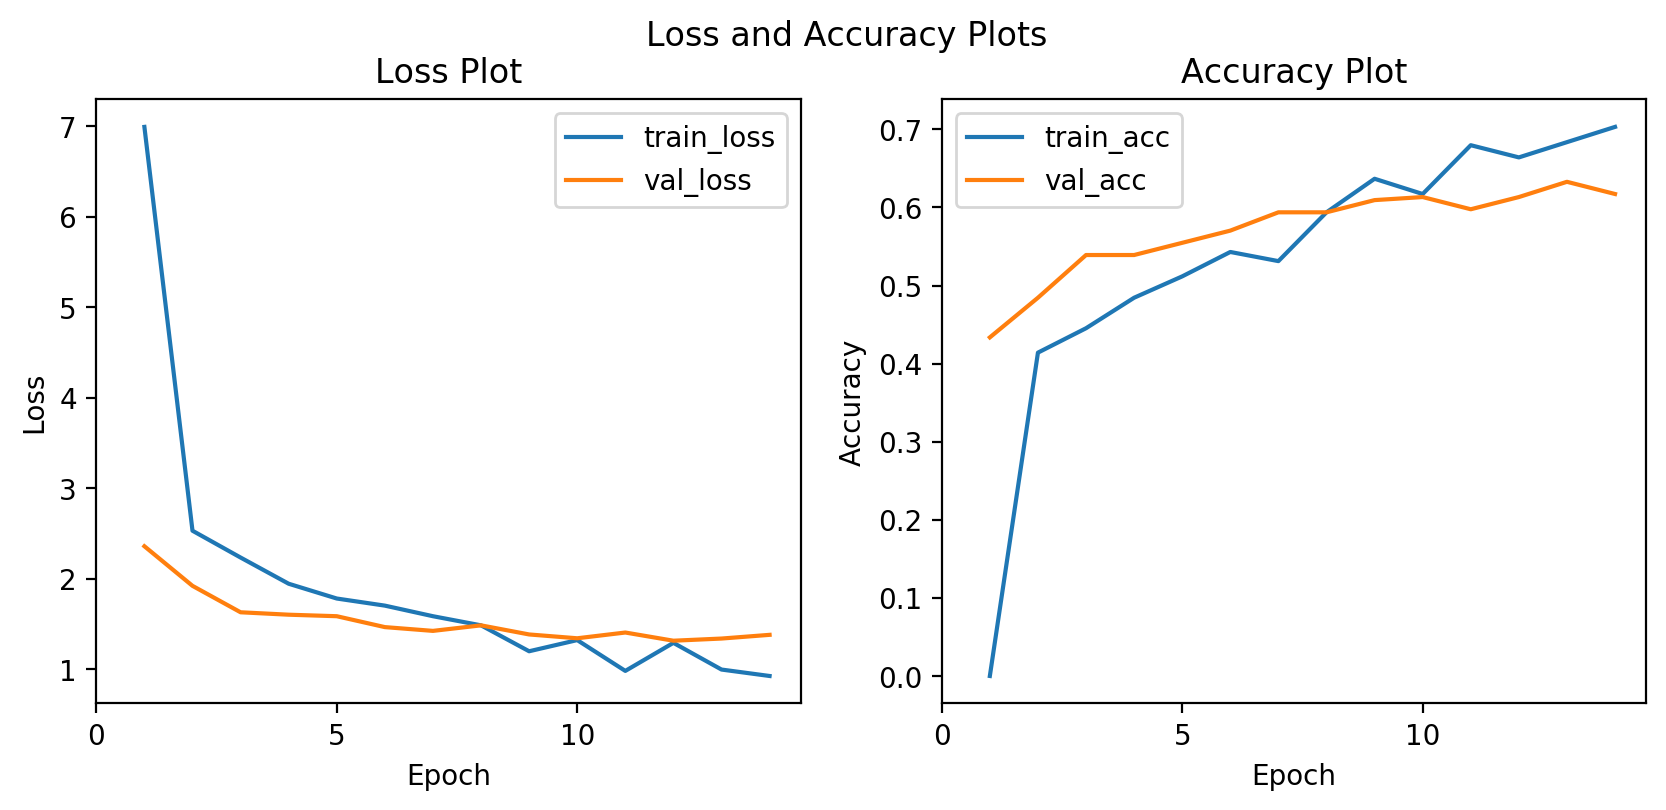

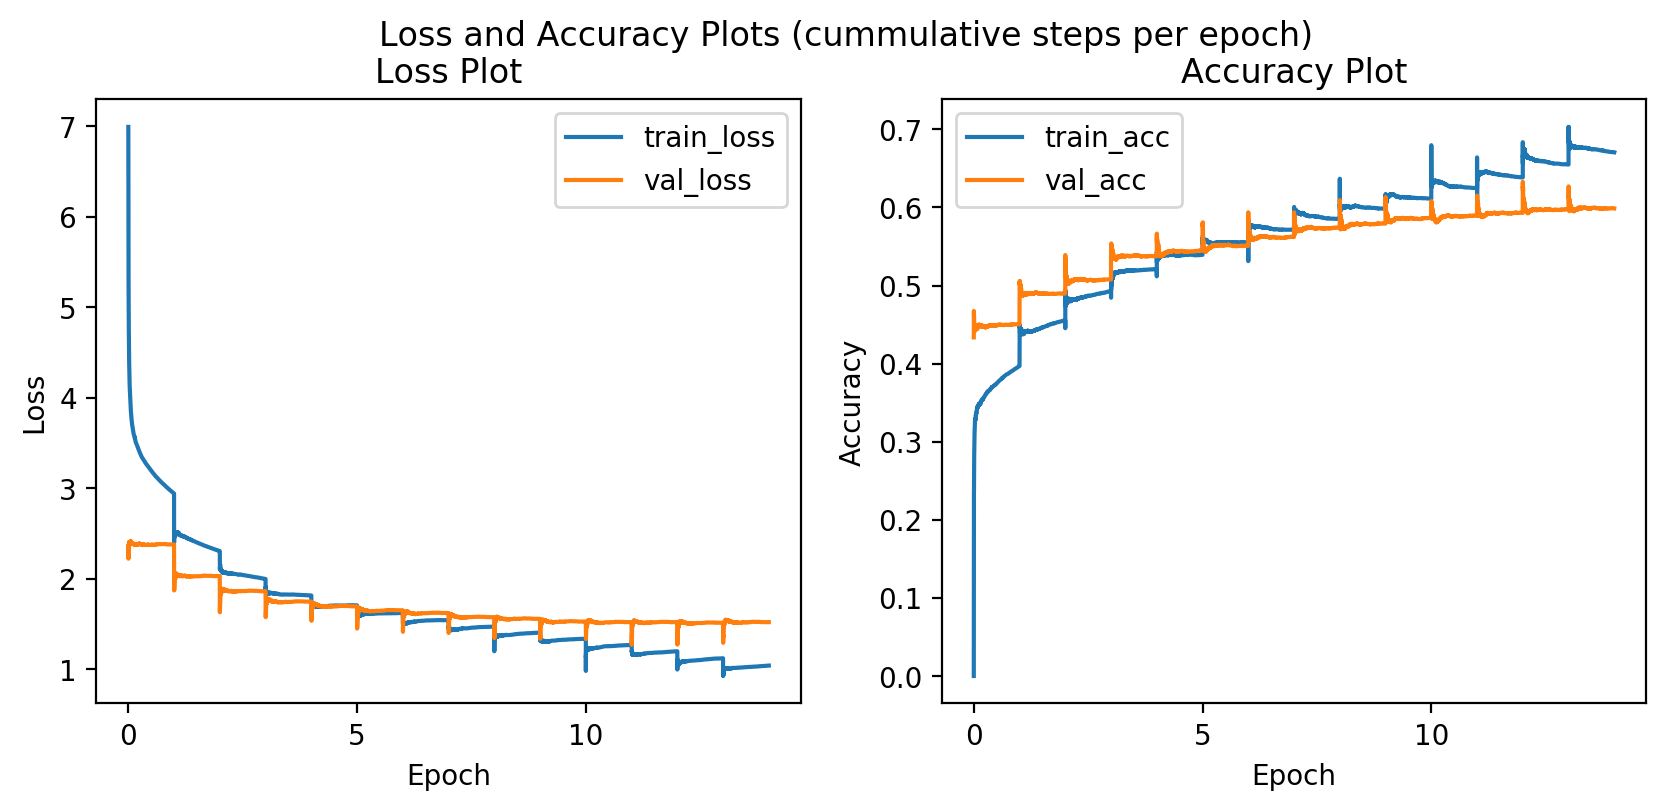

In [0]:
with open('saved/plot_data_att1.pkl','rb') as f:
    n_batches_train, n_batches_val, train_losses, train_accs, val_losses, val_accs = pickle.load(f) 

draw_plots(n_batches_train, n_batches_val, train_losses, train_accs, val_losses, val_accs,
    per_step_cummulative = False)

draw_plots(n_batches_train, n_batches_val, train_losses, train_accs, val_losses, val_accs,
    per_step_cummulative = True)

### Deep Learning Model 3: (Hierarchical  Question Image Co-Attention)

Here we are implementing hierarchical question image co-attention from paper: https://arxiv.org/pdf/1606.00061

![](readme_imgs/himg.jpg)
![](readme_imgs/hques.jpg)
![](readme_imgs/hatt.jpg)

#### Extracting 512x14x14 image features from resnet152 model:

In [0]:
# %load extract_resnet_features_512.py
import pickle
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision import models
from PIL import Image
import pickle
import jpeg4py as jpeg
import imghdr
import h5py
from tqdm import tqdm

from torch import nn
import torch.nn.functional  as F
from utils import *

transform = transforms.Compose([
transforms.Resize((448,448)),
transforms.ToTensor(),
transforms.Normalize(
mean=[0.485, 0.456, 0.406],
std=[0.229, 0.224, 0.225]
)])

class ImageDataset(Dataset):
    def __init__(self, json_list, split):
        self.imgids = list(set([i['image_id'] for i in json_list]))
        self.split = split


    def __len__(self):
        return len(self.imgids)

    def __getitem__(self, index):
        '''
        returns 2 tensors: image features tensor, imgid tensor.
        '''
        file = 'C:/'+self.split+'2014/COCO_'+self.split+'2014_'+str(self.imgids[index]).rjust(12, '0')+'.jpg'
        if(imghdr.what(file) == 'jpeg'):
            item = {'image': transform(Image.fromarray(jpeg.JPEG(file).decode()))}
        else:
            item = {'image': transform(Image.open(file).convert('RGB'))}

        item['id'] = self.imgids[index]
        return item

if __name__ == '__main__':

    num_workers = int(sys.argv[1])
    batch_size = int(sys.argv[2])
    split = sys.argv[3]
    
    resnet =  models.resnet152(pretrained = True)
    
    # modifing layer 4 to output 512X14X14 dim vector
    resnet.layer4[-1] = nn.Sequential(*list(resnet.layer4[-1].children())[:2])

    # removing last avg_pool and dense layer
    resnet = nn.Sequential(*list(resnet.children())[:-2])


    with open('train_val_lists.pkl', 'rb') as f:
        train_list, val_list = pickle.load(f)

    if(split == 'train'):
        list_json = train_list

    if(split == 'val'):
        list_json = val_list


    img_loader = DataLoader(
        ImageDataset(list_json, split),
        batch_size= batch_size,
        num_workers=num_workers,
        shuffle=False,
        pin_memory=True,
        )

    del train_list
    del val_list
    del list_json

    resnet.to('cuda')
    resnet.eval()
    
    with h5py.File(img_loader.dataset.split+'_imgs_resnet_512.h5', libver='latest', mode = 'w') as f:
        img_features = f.create_dataset('img_features', shape=(len(img_loader.dataset), 512, 14, 14), dtype='float16')
        img_ids = f.create_dataset('img_ids', shape=(len(img_loader.dataset),), dtype='int32')

        i = j = 0
        for data in tqdm(img_loader):
            imgs = data['image'].to('cuda')

            with torch.no_grad():
                out = resnet(imgs)

            j = i + imgs.size(0)
            img_features[i:j, :, :] = out.cpu().numpy().astype('float16')
            img_ids[i:j] = data['id'].numpy().astype('int32')
            i = j


In [0]:
# num_workers = 3, batch_size = 64, split = 'train'
%run extract_resnet_features_512.py 3 64 train

100%|██████████████████████████████████████████████████████████████████████████████| 1294/1294 [52:22<00:00,  2.43s/it]


In [0]:
# num_workers = 3, batch_size = 64, split = 'val'
%run extract_resnet_features_512.py 3 64 val

100%|████████████████████████████████████████████████████████████████████████████████| 633/633 [25:06<00:00,  2.38s/it]


### Model Definition:

In [0]:
class Hierarchical_CoAtt(nn.Module):

    def __init__(self, vocab_size, embed_dim = 512, q_len = 25):
        super().__init__()

        self.dropout = nn.Dropout(0.5)
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx = 0)
        self.fc_embed = nn.Linear(embed_dim, embed_dim)

        # appropriately zero padded the inputs of conv to have same dimensions after operations.
        self.unigram_conv = nn.Conv1d(embed_dim, embed_dim, 1, padding=0)
        self.bigram_conv  = nn.Conv1d(embed_dim, embed_dim, 2, padding=0)
        self.trigram_conv = nn.Conv1d(embed_dim, embed_dim, 3, padding=1)

        # to maxpool the outputs of unigrams, bigrams and trigrams
        self.maxpool = nn.MaxPool2d((3, 1))
        self.lstm = nn.LSTM(embed_dim, embed_dim, num_layers=3, batch_first = True)

        # Below are weight matrices used in the papers
        self.W_b = nn.Parameter(torch.randn(embed_dim, embed_dim))
        self.W_v = nn.Parameter(torch.randn(q_len, embed_dim))
        self.W_q = nn.Parameter(torch.randn(q_len, embed_dim))
        self.w_hv = nn.Parameter(torch.randn(q_len, 1))
        self.w_hq = nn.Parameter(torch.randn(q_len, 1))

        self.W_w = nn.Linear(embed_dim, embed_dim) # Dense layer for image, word parallel co-attention
        self.W_p = nn.Linear(embed_dim*2, embed_dim) # Dense layer for image, phrase parallel co-attention
        self.W_s = nn.Linear(embed_dim*2, 1024) # Dense layer for image, sentence parallel co-attention

        self.fc = nn.Linear(1024, 1000)

        self.init_weights()

    def forward(self, image, question):

        # [batch_size, 512, 14, 14] to [batch_size, 512, 14x14]
        image = image.view(image.size(0), image.size(1), -1)

        # [batch_size, 25, 512]
        words = torch.tanh(self.fc_embed(self.embed(question)))
        words = words.permute(0, 2, 1)   # [batch_size, 512, 25], transposed to do conv operation

        # [batch_size, 512, 25] to [batch_size, 512, 1, 25]
        unigrams = torch.unsqueeze(torch.tanh(self.unigram_conv(words)), 2)

        # [batch_size, 512, 25] to [batch_size, 512, 1, 25]
        bigram_padded_input = F.pad(words, (0,1), mode='constant', value = 0) # since the length is even, pad at one side only.
        bigrams  = torch.unsqueeze(torch.tanh(self.bigram_conv(bigram_padded_input)), 2)

        # [batch_size, 512, 25] to [batch_size, 512, 1, 25]
        trigrams = torch.unsqueeze(torch.tanh(self.trigram_conv(words)),2)

        words = words.permute(0, 2, 1)

        # [batch_size, 512, 3,  25] to [batch_size, 512, 25]
        phrase = torch.squeeze(self.maxpool(torch.cat((unigrams, bigrams, trigrams), 2)), 2)
        phrase = phrase.permute(0, 2, 1)

        # [batch_size, 512, 25] to [batch_size, 512, 25]
        sentence, _ = self.lstm(phrase)

        # Applying Hierarchical CoAttention
        v_word, q_word = self.parallel_co_attention(image, words)
        v_phrase, q_phrase = self.parallel_co_attention(image, phrase)
        v_sent, q_sent = self.parallel_co_attention(image, sentence)

        # [batch_size, 512]
        h_w = torch.tanh(self.W_w(q_word + v_word))

        # [batch_size, 512]
        h_p = torch.tanh(self.W_p(torch.cat(((q_phrase + v_phrase), h_w), dim=1)))

        # [batch_size, 512] to [batch_size, 1024]
        h_s = self.dropout(torch.tanh(self.W_s(torch.cat(((q_sent + v_sent), h_p), dim=1))))

        # [batch_size, 1024] to [batch_size, 1000]
        output = F.softmax(self.fc(h_s), dim = 1)

        return output

    def parallel_co_attention(self, V, Q):
        # [batch_size, 25, 512] X ([batch_size, 512] X [batch_size, 512, 196]) = [batch_size, 25, 196]
        C = torch.matmul(Q, torch.matmul(self.W_b, V))

        # ([batch_size, 25, 512] X [batch_size, 512, 196]) + (([batch_size, 25, 512] X [batch_size, 512, 25]) X [batch_size, 25, 196])
        # = [batch_size, 25, 196]
        H_v = torch.tanh(torch.matmul(self.W_v, V) + torch.matmul(torch.matmul(self.W_q, Q.permute(0, 2, 1)), C))

        # ([batch_size, 25, 512] X [batch_size, 512, 25]) + (([batch_size, 25, 512] X [batch_size, 512, 196]) X [batch_size, 196, 25])
        # = [batch_size, 25, 25]
        H_q = torch.tanh(torch.matmul(self.W_q, Q.permute(0, 2, 1)) + torch.matmul(torch.matmul(self.W_v, V), C.permute(0, 2, 1)))

        # ([batch_size, 1, 25] X [batch_size, 25, 196]) to [batch_size, 1, 196]
        a_v = F.softmax(torch.matmul(torch.t(self.w_hv), H_v), dim=2)

        # ([batch_size, 1, 25] X [batch_size, 25, 25]) to [batch_size, 1, 25]
        a_q = F.softmax(torch.matmul(torch.t(self.w_hq), H_q), dim=2)

        # [batch_size, 1, 196] X [batch_size, 196, 512] to [batch_size, 512]
        v = torch.squeeze(torch.matmul(a_v, V.permute(0, 2, 1)), 1)

        # [batch_size, 1, 25] X [batch_size, 25, 512] to [batch_size, 512]
        q = torch.squeeze(torch.matmul(a_q, Q), 1)

        return v, q

    def init_weights(self):
        # kaiming_uniform is same as he_uniform initialization
        init = torch.nn.init.kaiming_uniform_
        for layer in self.lstm.all_weights:
            for hidden in layer[:2]:
                init(hidden)

        init(self.fc_embed.weight)

        init(self.unigram_conv.weight)
        init(self.bigram_conv.weight)
        init(self.trigram_conv.weight)

        init(self.W_w.weight)
        init(self.W_p.weight)
        init(self.W_s.weight)
        init(self.fc.weight)


NOTE: The above model definition and utility functions are stored in utils_co.py 

In [0]:
# %load coatt_model_training.py
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision import models
import re
import pickle
from torch.optim import lr_scheduler
import h5py


from torch import nn
import torch.nn.functional  as F
from utils_co import *


SEED = 1234
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.benchmark=True


class VQADataset_IH(Dataset):
    def __init__(self, json_list, question_vocab, answer_vocab, split = None):
        self.text_data = json_list
        self.split = split

        self.questions_encoded = encode_questions(self.text_data, question_vocab)
        self.answers_encoded, self.multi_answers = encode_answers(self.text_data, answer_vocab)

    def __len__(self):
        return len(self.text_data)

    def __getitem__(self, index):

        # h5 objects cant be pickled when declared in __init__
        if not hasattr(self, 'img_h5'):
            self.img_h5 = h5py.File('C:/'+self.split+'_imgs_resnet_512.h5', libver='latest', mode = 'r')
            self.img_features = self.img_h5['img_features']
            img_ids_list = list(self.img_h5['img_ids'])
            self.img_ids = {}
            for i in range(len(img_ids_list)):
                self.img_ids[img_ids_list[i]] = i

        '''
        returns 4 tensors: image tensor, encoded question tensor, encoded answer tensor, multi answer tensor.
        '''
        item = {}
        item['image'] = torch.tensor(self.img_features[self.img_ids[self.text_data[index]['image_id']]], dtype = torch.float32)
        item['question'] = torch.tensor(self.questions_encoded[index])
        item['answer'] = torch.tensor(self.answers_encoded[index], dtype = torch.long)
        item['multi_answer'] = torch.tensor(self.multi_answers[index], dtype = torch.long)
        return item


if __name__ == '__main__':

    num_workers = int(sys.argv[1])
    batch_size = int(sys.argv[2])

    with open('vocab.pkl', 'rb') as f:
        question_vocab, answer_vocab = pickle.load(f)

    with open('train_val_lists.pkl', 'rb') as f:
        train_list, val_list = pickle.load(f)

    train_dataset = VQADataset_IH(train_list,
                                 question_vocab,
                                 answer_vocab,
                                split = 'train')
    val_dataset = VQADataset_IH(val_list,
                                question_vocab,
                                answer_vocab,
                                split = 'val')

    del train_list
    del val_list

    train_dataloader = DataLoader(train_dataset,
                                batch_size=batch_size, shuffle = True, num_workers = num_workers, pin_memory = True)

    val_dataloader = DataLoader(val_dataset,
                                batch_size=batch_size, shuffle = False, num_workers = num_workers, pin_memory = True)



    device = torch.device('cuda:0')
    epochs = 50

    model = Hierarchical_CoAtt(len(question_vocab),512, 25)
    optimizer = torch.optim.Adamax(model.parameters(), lr =0.0003)

    onecycle_scheduler = lr_scheduler.OneCycleLR(optimizer, steps_per_epoch = train_dataloader.__len__(), max_lr = 0.0012, epochs = epochs)
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    unk_answer_idx = answer_vocab['<UNK>'] # to ignore unknown answer index
    criterion = torch.nn.NLLLoss(ignore_index = unk_answer_idx).to(device)

    model.to(device)

    n_batches_train = train_dataloader.__len__()
    n_batches_val = val_dataloader.__len__()
    train_len = train_dataloader.dataset.__len__()
    val_len = val_dataloader.dataset.__len__()

    min_loss = 99

    for epoch in range(epochs):

        start = dt.now()
        train_loss = 0
        train_correct = 0
        model = model.train()

        for batch, data in enumerate(train_dataloader):

            # unzipping data and loading it to GPU
            data['image'], data['question'] = data['image'].to(device), data['question'].to(device)
            multi_ans = data['multi_answer']
            answers = data['answer']

            # zeroing the previous optimizer calculations
            optimizer.zero_grad()

            output = model(data['image'], data['question'])

            # modifying answers tensor by replacing wrong output answers with possible multi answers.
            predictions = torch.argmax(output.cpu(), 1)
            indices = torch.where(~(answers == predictions))[0]
            for idx in indices:
                if predictions[idx] in multi_ans[idx]:
                    answers[idx] = multi_ans[idx][torch.where(multi_ans[idx] == predictions[idx])[0].item()]

            loss = criterion(torch.log(output+1e-6),  answers.cuda())

            # backpropagating loss
            loss.backward()

            optimizer.step()
            onecycle_scheduler.step()

            predictions[predictions == unk_answer_idx] = -1 #to ignore unknown answer
            train_correct += (predictions == answers).sum().item()
            train_loss += loss.item()

            train_accs.append(train_correct/(min((batch+1)*batch_size, train_len)))
            train_losses.append(train_loss/(batch+1))
            printout = '\r Epoch: {}  Batches: {}/{} loss: {:.5f} acc: {:.4f}'.format(epoch+1, batch+1, n_batches_train, train_losses[-1], train_accs[-1], train_len)
            print(printout, end = '')

        val_correct = 0
        val_loss = 0
        with torch.no_grad():
            model = model.eval()
            for batch, data in enumerate(val_dataloader):

                data['image'], data['question'] = data['image'].to(device), data['question'].to(device)
                multi_ans = data['multi_answer']
                answers = data['answer']

                output = model(data['image'], data['question'])

                # modifying answers tensor by replacing wrong output answers with possible multi answers.
                predictions = torch.argmax(output.cpu(), 1)
                indices = torch.where(~(answers == predictions))[0]
                for idx in indices:
                    if predictions[idx] in multi_ans[idx]:
                        answers[idx] = multi_ans[idx][torch.where(multi_ans[idx] == predictions[idx])[0].item()]

                vloss = criterion(torch.log(output+1e-6),  answers.cuda())

                predictions[predictions == unk_answer_idx] = -1 #to ignore unknown answer
                val_correct += (predictions == answers).sum().item()
                val_loss += vloss.item()

                val_accs.append(val_correct/(min((batch+1)*batch_size, val_len)))
                val_losses.append(val_loss/(batch+1))
                print(printout+' val_batches : {}/{} val_loss: {:.5f} val_acc: {:.4f}'.format(batch+1, n_batches_val, val_losses[-1], val_accs[-1]), end = '')
            print(' [{}]'.format(dt.now()-start))

        torch.save(model.state_dict(), 'saved/model_coatt1_state_dict')

         # saving accuracies and losses for plotting later.
        with open('saved/plot_data_coatt1.pkl','wb') as f:
            pickle.dump([n_batches_train, n_batches_val, train_losses, train_accs, val_losses, val_accs], f)

        # Earlystopping with patience 5.
        if(val_losses[-1] < min_loss):
            # saving best model to disk
            torch.save(model.state_dict(), 'saved/model_coatt1_es_state_dict')
            min_loss = val_losses[-1]
            patience = 0
        else:
            patience += 1
        if(patience == 3):
            print('\n EarlyStopped.')
            break


In [0]:
# num_workers = 3 batch_size = 256
%run coatt_model_training.py 3 256

 Epoch: 1  Batches: 1734/1734 loss: 4.64268 acc: 0.2802 val_batches : 838/838 val_loss: 3.71254 val_acc: 0.3496 [0:13:27.272607]
 Epoch: 2  Batches: 1734/1734 loss: 3.80445 acc: 0.3349 val_batches : 838/838 val_loss: 3.38668 val_acc: 0.3696 [0:13:16.885624]
 Epoch: 3  Batches: 1734/1734 loss: 3.48497 acc: 0.3540 val_batches : 838/838 val_loss: 3.05538 val_acc: 0.3956 [0:12:57.885350]
 Epoch: 4  Batches: 1734/1734 loss: 3.16666 acc: 0.3778 val_batches : 838/838 val_loss: 2.82838 val_acc: 0.4173 [0:12:56.392129]
 Epoch: 5  Batches: 1734/1734 loss: 2.99351 acc: 0.3943 val_batches : 838/838 val_loss: 2.64874 val_acc: 0.4308 [0:13:07.540023]
 Epoch: 6  Batches: 1734/1734 loss: 2.76076 acc: 0.4138 val_batches : 838/838 val_loss: 2.46423 val_acc: 0.4514 [0:13:01.264162]
 Epoch: 7  Batches: 1734/1734 loss: 2.57396 acc: 0.4302 val_batches : 838/838 val_loss: 2.31301 val_acc: 0.4658 [0:13:12.801469]
 Epoch: 8  Batches: 1734/1734 loss: 2.42168 acc: 0.4470 val_batches : 838/838 val_loss: 2.20795 v

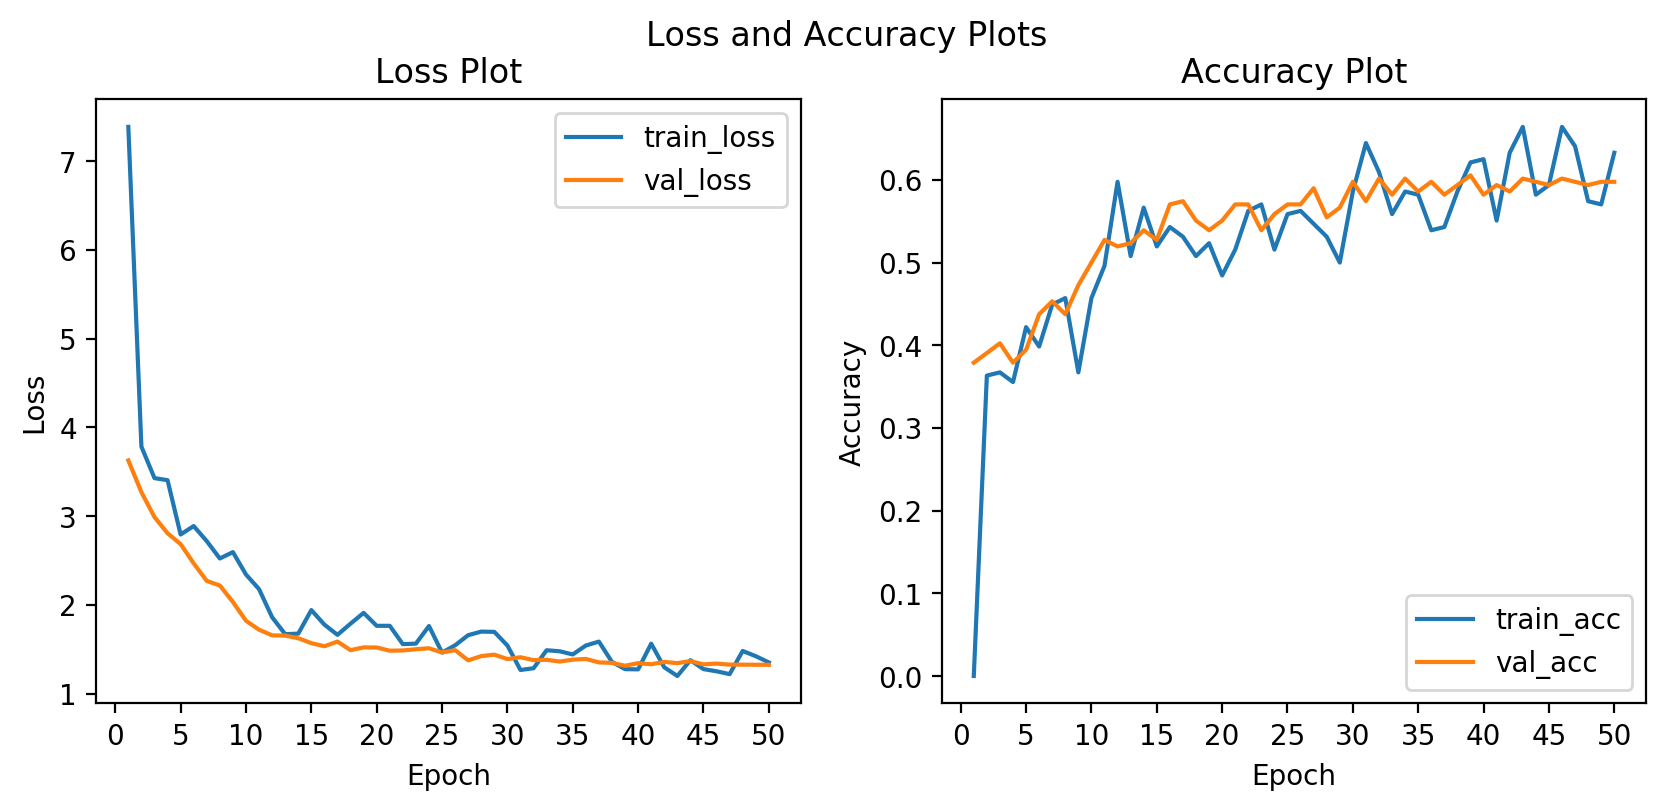

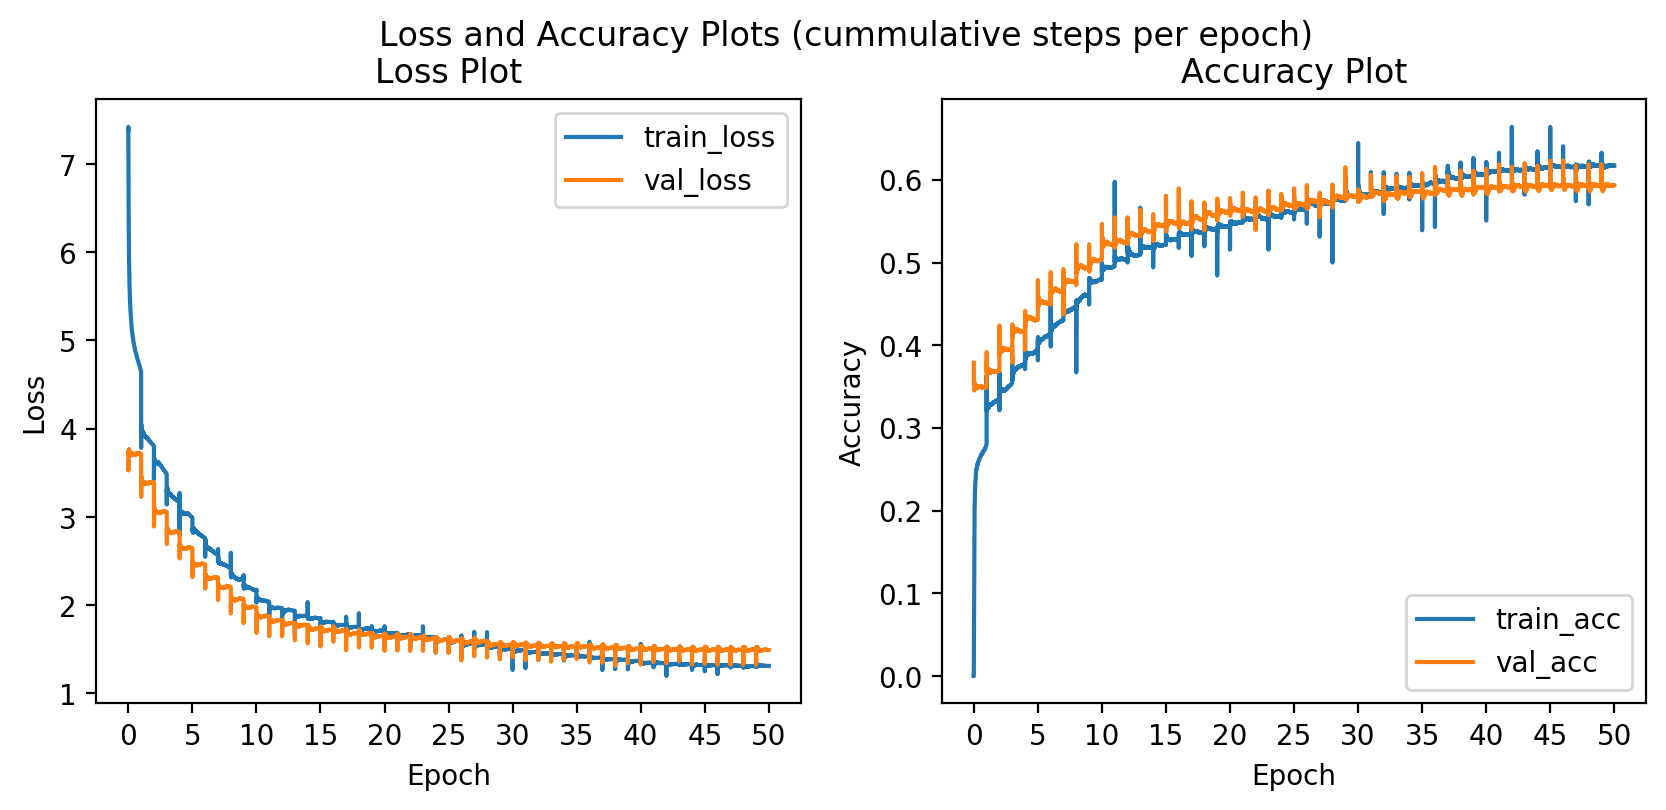

In [0]:
with open('saved/plot_data_coatt1.pkl','rb') as f:
    n_batches_train, n_batches_val, train_losses, train_accs, val_losses, val_accs = pickle.load(f) 

draw_plots(n_batches_train, n_batches_val, train_losses, train_accs, val_losses, val_accs,
    per_step_cummulative = False)

draw_plots(n_batches_train, n_batches_val, train_losses, train_accs, val_losses, val_accs,
    per_step_cummulative = True)

## Checking both model outputs with image(VQADemo):

### Model prediction pipeline:

In [0]:
# the model definitions are stored in .py files
# Model definitions are required to load the state_dict of model
import deeperlstm_att 
import deeperlstm
import hierarchical_coatt

In [0]:
from torchvision import transforms, models
from PIL import Image
import re
import pickle

from torch import nn
import torch.nn.functional  as F
import torch

class VQADemo:
    def __init__(self):
        
        self.transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(                   
        mean=[0.485, 0.456, 0.406],                
        std=[0.229, 0.224, 0.225]                 
         )])
        
        with open('vocab.pkl', 'rb') as f:
            self.question_vocab, self.answer_vocab = pickle.load(f)
            
        self.answer_idx2word = {v: k for k, v in self.answer_vocab.items()}
        
        w_vgg19 =  models.vgg19_bn(pretrained = True)
        w_vgg19.classifier = nn.Sequential(*list(w_vgg19.classifier.children()))[:-3]
        self.vgg = w_vgg19.to('cpu').eval()

        w_resnet =  models.wide_resnet101_2(pretrained = True)
        w_resnet = nn.Sequential(*list(w_resnet.children())[:-3])
        resnet_mod = nn.Sequential(*list(w_resnet.children()))
        self.w_resnet = resnet_mod.to('cpu').eval()
        
        resnet =  models.resnet152(pretrained = True)
        resnet.layer4[-1] = nn.Sequential(*list(resnet.layer4[-1].children())[:2])
        self.resnet = nn.Sequential(*list(resnet.children())[:-2])
        
        self.model1 = deeperlstm.DeeperLSTM_QI(len(self.question_vocab), 4096).to('cpu')
        self.model1.load_state_dict(torch.load('saved/model_11_state_dict'))
        self.model1 = self.model1.eval()
        
        self.model2 = deeperlstm_att.DeeperLSTM_QI_Att(len(self.question_vocab), 1024).to('cpu')
        self.model2.load_state_dict(torch.load('saved/model_att1_state_dict'))
        self.model2 = self.model2.eval()
        
        self.model3 = hierarchical_coatt.Hierarchical_CoAtt(len(self.question_vocab),512, 25).to('cpu')
        self.model3.load_state_dict(torch.load('saved/model_coatt1_state_dict'))
        self.model3 = self.model3.eval()

        
    def predict(self, image, question, model):

        img = torch.unsqueeze(self.transform(Image.open(image).convert('RGB')), 0)

        if(model == '1'):
        
            ques = self.encode_question(question, self.question_vocab, 25)
            with torch.no_grad():
                img_feats = self.vgg(img)
                prediction = self.model1(img_feats, ques)
            answer_ids = torch.argsort(prediction, descending=True)[0][:3].tolist()
            answer_probs = prediction[0][answer_ids].tolist()
            answers = [self.answer_idx2word[id] for id in answer_ids]

        elif(model == '2'):

            ques = self.encode_question(question, self.question_vocab, 25)
            with torch.no_grad():
                img_feats = self.w_resnet(img)
                prediction = self.model2(img_feats, ques)
            answer_ids = torch.argsort(prediction, descending=True)[0][:3].tolist()
            answer_probs = prediction[0][answer_ids].tolist()
            answers = [self.answer_idx2word[id] for id in answer_ids]
            
        elif(model == '3'):

            ques = self.encode_question(question, self.question_vocab, 25)
            with torch.no_grad():
                img_feats = self.resnet(img)
                prediction = self.model3(img_feats, ques)
            answer_ids = torch.argsort(prediction, descending=True)[0][:3].tolist()
            answer_probs = prediction[0][answer_ids].tolist()
            answers = [self.answer_idx2word[id] for id in answer_ids]
    
        return answers, answer_probs
    
    def encode_question(self, question, vocab, max_length):
        q = [vocab.get(i, vocab['<UNK>']) for i in self.tokenize(question)]
        length = len(q)
        if(length < max_length):
            q += [vocab['<PAD>'] for i in range(max_length - length)]
        else:
            q = q[:max_length]   
        return torch.tensor(q, dtype = torch.long).unsqueeze(0) 
    
    def tokenize(self, sentence):
        sentence = sentence.lower()
        return [i for i in re.split(r"([-!\$#.\"',:? @~();\[\]/\\\+<>\n*&\^%=])", sentence) if
                i != '' and i != ' ' and i != '\n']

In [0]:
# Initializing VQADemo

vqademo = VQADemo()

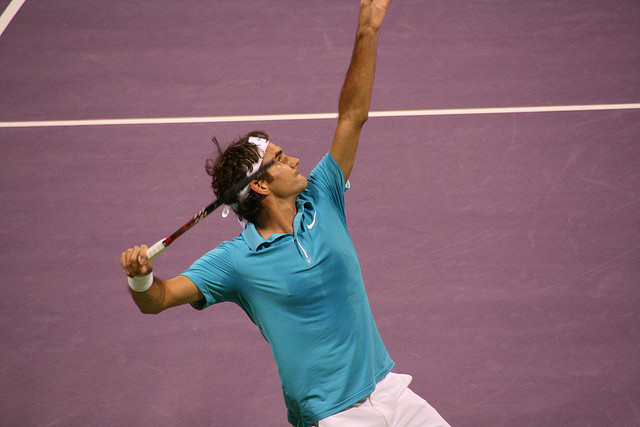

In [0]:
image = 'val2014/COCO_val2014_'+str(2235).rjust(12, '0')+'.jpg'
Image.open(image)

In [0]:
def check_questions(model_no):
    question = 'what is he doing?'

    print('Q:', question)
    predictions = vqademo.predict(image, question, model_no)
    for i in range(len(predictions[0])):
        print('A: {}  [{:.4f}]'.format(predictions[0][i], predictions[1][i]))

    question = 'what game is he playing?'
    print()
    print('Q:', question)
    predictions = vqademo.predict(image, question, model_no)
    for i in range(len(predictions[0])):
        print('A: {}  [{:.4f}]'.format(predictions[0][i], predictions[1][i]))

    question = 'what is the color of shirt?'
    print()
    print('Q:', question)
    predictions = vqademo.predict(image, question, model_no)
    for i in range(len(predictions[0])):
        print('A: {}  [{:.4f}]'.format(predictions[0][i], predictions[1][i]))

    question = 'what are we looking through?'
    print()
    print('Q:', question)
    predictions = vqademo.predict(image, question, model_no)
    for i in range(len(predictions[0])):
        print('A: {}  [{:.4f}]'.format(predictions[0][i], predictions[1][i]))

#### Checking Model 1 :

In [0]:
check_questions('1')

Q: what is he doing?
A: sitting  [0.0327]
A: standing  [0.0233]
A: eating  [0.0206]

Q: what game is he playing?
A: none  [0.0406]
A: frisbee  [0.0290]
A: nothing  [0.0187]

Q: what is the color of shirt?
A: white  [0.1486]
A: blue  [0.0746]
A: black  [0.0646]

Q: what are we looking through?
A: fence  [0.0555]
A: water  [0.0357]
A: tree  [0.0276]


#### Checking Model 2:

In [0]:
check_questions('2')

Q: what is he doing?
A: playing tennis  [0.7225]
A: playing baseball  [0.0710]
A: flying kite  [0.0468]

Q: what game is he playing?
A: tennis  [0.9400]
A: wii  [0.0230]
A: baseball  [0.0199]

Q: what is the color of shirt?
A: blue  [0.9515]
A: green  [0.0454]
A: gray  [0.0014]

Q: what are we looking through?
A: net  [0.4536]
A: window  [0.1118]
A: fence  [0.1095]


#### Checking Model 3:

In [0]:
check_questions('3')

Q: what is he doing?
A: sitting  [0.2005]
A: standing  [0.1710]
A: talking on phone  [0.1408]

Q: what game is he playing?
A: baseball  [0.6782]
A: tennis  [0.1407]
A: skateboarding  [0.0429]

Q: what is the color of shirt?
A: blue  [0.3902]
A: white  [0.2566]
A: green  [0.1112]

Q: what are we looking through?
A: grass  [0.1369]
A: fence  [0.1258]
A: tree  [0.0877]


### Validating different type of answers performance: (yes/no, number, other)

In [0]:
import pickle

with open('train_val_lists.pkl', 'rb') as f:
    train_list, val_list = pickle.load(f)

In [0]:
# all dataset classes and its required functions are stored in datasets.py
from datasets import *

In [0]:
device = 'cuda'
unk_answer_idx = answer_vocab['<UNK>'] # to ignore unknown answer index
criterion = torch.nn.NLLLoss(ignore_index = unk_answer_idx).to(device)
    
def validate(model, val_dataloader):
    
    n_batches_val = val_dataloader.__len__()
    val_len = val_dataloader.dataset.__len__()
    batch_size = int(val_len/n_batches_val)
    
    val_loss  = 0
    val_correct = 0

    with torch.no_grad():
            model = model.eval()
            for batch, data in enumerate(val_dataloader):

                data['image'], data['question'] = data['image'].to(device), data['question'].to(device)
                answers = data['answer']

                output = model(data['image'], data['question'])
                predictions = torch.argmax(output.cpu(), 1)
                
                
                # modifying answers tensor by replacing wrong output answers with possible multi answers.
                multi_ans = data['multi_answer']
                indices = torch.where(~(answers == predictions))[0]
                for idx in indices:
                    if predictions[idx] in multi_ans[idx]:
                        answers[idx] = multi_ans[idx][torch.where(multi_ans[idx] == predictions[idx])[0].item()]

                vloss = criterion(torch.log(output+0.000001),  answers.cuda())

                predictions[predictions == unk_answer_idx] = -1 #to ignore unknown answer
                val_correct += (predictions == answers).sum().item()
                val_loss += vloss.item()

                print('\r val_batches : {}/{} val_loss: {:.5f} val_acc: {:.4f}'.format(batch+1, n_batches_val, val_loss/(batch+1), val_correct/(min((batch+1)*batch_size, val_len))), end = '')


In [0]:
# loading vgg pretrained features from previously saved dictionaries.
with open('img_feats_dicts_vgg19.pickle', 'rb') as f:
    img_feat_dict_train = pickle.load(f)
    img_feat_dict_val = pickle.load(f)

In [0]:
import deeperlstm_att 
import deeperlstm

model1 = deeperlstm.DeeperLSTM_QI(len(question_vocab), 4096).to('cuda')
model1.load_state_dict(torch.load('saved/model_11_state_dict'))

model2 = deeperlstm_att.DeeperLSTM_QI_Att(len(question_vocab), 1024).to('cuda')
model2.load_state_dict(torch.load('saved/model_att1_state_dict'))

model3 = hierarchical_coatt.Hierarchical_CoAtt(len(question_vocab),512, 25).to('cuda')
model3.load_state_dict(torch.load('saved/model_coatt1_state_dict'))

<All keys matched successfully>

### Vaildating answer_type: yes/no performance:

In [0]:
val_list_yrn = filter_dataset(val_list, 'yes/no')

#### Model 1:

In [0]:
val_dataloader = DataLoader(VQADataset(val_list_yrn, 
                                        question_vocab,
                                        answer_vocab,
                                        split = 'val',
                                        val_img_feats = img_feat_dict_val 
                                    ),
                                   batch_size=256, shuffle = False)
print('Multi_choice: ')
validate(model1, val_dataloader)

Multi_choice: 
 val_batches : 315/315 val_loss: 0.54899 val_acc: 0.7861

#### Model 2:

In [0]:
val_dataloader = DataLoader(VQADataset_I(val_list_yrn, 
                                        question_vocab,
                                        answer_vocab,
                                        split = 'val'
                                    ),
                                   batch_size=256, shuffle = False)
print('Multi_choice: ')
validate(model2, val_dataloader)

Multi_choice: 
 val_batches : 315/315 val_loss: 0.53883 val_acc: 0.7904

#### Model 3:

In [0]:
val_dataloader = DataLoader(VQADataset_IH(val_list_yrn, 
                                        question_vocab,
                                        answer_vocab,
                                        split = 'val'
                                    ),
                                   batch_size=256, shuffle = False)
print('Multi_choice: ')
validate(model3, val_dataloader)

Multi_choice: 
 val_batches : 315/315 val_loss: 0.54348 val_acc: 0.7754

### Validating answer_type: number performance:

In [0]:
val_list_number = filter_dataset(val_list, 'number')

#### Model 1:

In [0]:
val_dataloader = DataLoader(VQADataset(val_list_number, 
                                        question_vocab,
                                        answer_vocab,
                                        split = 'val',
                                        val_img_feats = img_feat_dict_val 
                                    ),
                                   batch_size=256, shuffle = False)
print('Multi_choice: ')
validate(model1, val_dataloader)

Multi_choice: 
 val_batches : 110/110 val_loss: 2.02863 val_acc: 0.4261

#### Model 2:

In [0]:
val_dataloader = DataLoader(VQADataset_I(val_list_number, 
                                        question_vocab,
                                        answer_vocab,
                                        split = 'val'
                                    ),
                                   batch_size=256, shuffle = False)
print('Multi_choice: ')
validate(model2, val_dataloader)

Multi_choice: 
 val_batches : 110/110 val_loss: 1.98889 val_acc: 0.4367

#### Model 3:

In [0]:
val_dataloader = DataLoader(VQADataset_IH(val_list_number, 
                                        question_vocab,
                                        answer_vocab,
                                        split = 'val'
                                    ),
                                   batch_size=256, shuffle = False)
print('Multi_choice: ')
validate(model3, val_dataloader)

Multi_choice: 
 val_batches : 110/110 val_loss: 2.04914 val_acc: 0.4129

### Validating answer_type: other performance:

In [0]:
val_list_other = filter_dataset(val_list, 'other')


#### Model 1:

In [0]:
val_dataloader = DataLoader(VQADataset(val_list_other, 
                                        question_vocab,
                                        answer_vocab,
                                        split = 'val',
                                        val_img_feats = img_feat_dict_val 
                                    ),
                                   batch_size=256, shuffle = False)
print('Multi_choice: ')
validate(model1, val_dataloader)

Multi_choice: 
 val_batches : 413/413 val_loss: 2.26338 val_acc: 0.4869

#### Model 2:

In [0]:
val_dataloader = DataLoader(VQADataset_I(val_list_other, 
                                        question_vocab,
                                        answer_vocab,
                                        split = 'val'
                                    ),
                                   batch_size=256, shuffle = False)

print('Multi_choice: ')
validate(model2, val_dataloader)

Multi_choice: 
 val_batches : 413/413 val_loss: 2.20310 val_acc: 0.4995

#### Model 3:

In [0]:
val_dataloader = DataLoader(VQADataset_IH(val_list_other, 
                                        question_vocab,
                                        answer_vocab,
                                        split = 'val'
                                    ),
                                   batch_size=256, shuffle = False)
print('Multi_choice: ')
validate(model3, val_dataloader)

Multi_choice: 
 val_batches : 413/413 val_loss: 2.12751 val_acc: 0.5067

## What we did in this case study?

<b>We referred our base model from paper-1: <i>arXiv:1505.00468</i>
    and tried adding image attention mentioned in paper-2: <i>arXiv:1704.03162</i>
    and for last one, used hierarchical co-attention from <i>arXiv:1606.00061</i></b>

- Used visualqa 2017 dataset which has train and val splits already.
- The metric used while training is Multiple-choice accuracy from the paper-1.
<br><br>
- <b> For Model-1: </b> Image features of 4096 dim are extracted from vgg19_bn model last before layer and saved to disk in dict fashion. We did this to speed up the training while tuning the models.<br>
- <b> For Model-2: </b> Image features of 1024x14x14 are extracted from wide_resnet_101_2 model excluding last two modules and saved to disk in .h5 dataset file for fast accessing.
- <b> For Model-3: </b> Image features of 512x14x14 are extracted from resnet_152 model excluding last layers and saved to disk in .h5 dataset file for fast accessing.
<br><br>
- Questions are encoded according to the vocab created.
- Considered only 1000 labels for answers as per the paper-1.
- Marked the answers as &lt;UNK&gt; if they are not present in our answer vocab.
- Multiple choice answers are uniquely selected. If the open ended answer is not in the vocab, then random answer from multiple choice answers is selected. Otherwise &lt;UNK&gt; is added.
- Now, the data is prepared to batches with batch_size:256 using torch Dataset and Dataloader classes.
<br><br>
<b> Model Definitions </b>:
<br>
- Most activation functions is replaced with gelu activation as it is known for   best outcomes in NLP problems.
- Used kaiming_uniform (he_uniform) weight initialization on all layers.
- As we have already used the Softmax at output layer. So we have to use         NLLLoss instead of CrossEntropyLoss.
- Used Adamax optimizer with base_lr : 0.001 as it known for better performance   than adam for model 1 and 2. Used base_lr : 0.0003 for model 3.
- Used OneCyclicLR learning rate scheduler with max_lr: 0.005 (5 times the base   lr) for model 1 and 2, max_lr: 0.0012 for model 3. As this learning rate scheduler improves the training performance and   supports faster convergence in lesser epochs. Moreover, we don't need to tune our lr.
<br><br>
<b> Model training </b>:
- As we have to train our models with multiple choice answers, for each answer batch, we checked for wrongly predicted answers and tried to replace them with possible multiple choice answer and forward passed to model.
- And used those modified answers for loss and accuracy calculation. For loss and accuracy calculation, we also ignored the &lt;UNK&gt; answer.
- torch.log() is applied to the outputs as they are from softmax layer and NLLLoss works only with log_softmax.
- Earlystopped the model with patience = 3.
- Saved the model state dicts for every epoch and also the model before earlystopped is also saved. These saved model can be used for inference later.
- For faster data loading we have wrapped the training code under &lowbar;&lowbar;main&lowbar;&lowbar; wrapper to make torch dataloader num_worker>0 work. So, placed the required code in the seperate .py files but everything is available in this notebook.
    

## Epilogue:

We can see from VQADemo, that second model with attention has given better answers than other models as with the attention everything is more clearer to the model. Moreover, for first model, we used only 4096 img features but in next models, we have used 1024x14x14 and 512x14x14 image features which are ton load of features than the latter.

Since our metric is multiple choice accuracy, we also have to compare them.

In [0]:
from  prettytable import PrettyTable 
print('|---------------- Multiple Choice Accuracy -------------|')
x = PrettyTable(["Model", "All", "Yes/No", "Number", "other"]) 
x.add_row(["DeeperLSTM_QI",0.5895,0.7861,0.4261,0.4869])
x.add_row(["DeeperLSTM_QI_Att",0.5988,0.7904,0.4367,0.4995])
x.add_row(["Hierarchical_CoAtt",0.5936,0.7754,0.4129,0.5067])

print(x)

|---------------- Multiple Choice Accuracy -------------|
+--------------------+--------+--------+--------+--------+
|       Model        |  All   | Yes/No | Number | other  |
+--------------------+--------+--------+--------+--------+
|   DeeperLSTM_QI    | 0.5895 | 0.7861 | 0.4261 | 0.4869 |
| DeeperLSTM_QI_Att  | 0.5988 | 0.7904 | 0.4367 | 0.4995 |
| Hierarchical_CoAtt | 0.5936 | 0.7754 | 0.4129 | 0.5067 |
+--------------------+--------+--------+--------+--------+


### <center> End of the Case Study.